<a href="https://colab.research.google.com/github/nteuthorn/Thinkful-Capstone-3/blob/master/Capstone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Investigatory Stops by the Chicago Police Department

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install prince

In [3]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import time
import itertools
import prince as pn
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Dataset:
https://www.kaggle.com/milesius/cpd-investigatory-stop-reports

# Import and clean data

In [4]:
#Import data

df2016 = pd.read_csv('/content/drive/MyDrive/Data Science Projects/Thinkful/Completed/Capstone 3/01-JAN-2016_28-FEB-2017.csv')
df2016.drop('RD_NO', axis=1, inplace=True)

df2017 = pd.read_csv('/content/drive/MyDrive/Data Science Projects/Thinkful/Completed/Capstone 3/29-FEB-2017_16-JAN-2018.csv')

df = pd.concat([df2016, df2017])
df_clean = df.copy()

#Remove columns with 0 or 1 unique values
df_clean.drop(['JUVENILE_I', 'WARD', 'RES_WARD', 'BUS_WARD', 'TYPE_CD', 'COMPLETION_I', 'OTHER_CONTRABAND_I', 
               'OTHER_CONTRABAND_DESCR', 'SEARCH_OTHER_CONTRABAND_I', 'SEARCH_OTHER_CONTRABAND_DESCR', 
               'CITED_VIOLATIONS_CD'], axis=1, inplace=True)

#Remove columns that are not useful/too many unique string values
df_clean.drop(['CONTACT_CARD_ID', 'CARD_NO', 'SUBMITTING_BEAT_CD', 'CLOTHING_DESCR', 'HOTSPOT_NO', 'EVENT_NO', 'MISSION_NO', 
               'CPD_UNIT_NO', 'CREATED_BY', 'CREATED_DATE', 'MODIFIED_BY', 'MODIFIED_DATE', 'AGE_TO', 'STREET_NO', 
               'STREET_DIRECTION_CD', 'APT_NO', 'STREET_NME', 'CITY', 'STATE_CD', 'ZIP_CD', 'HALF_ADDRESS_I', 'DISTRICT', 
               'SECTOR', 'BEAT', 'RES_DISTRICT', 'RES_SECTOR', 'RES_BEAT', 'BUS_DISTRICT', 'BUS_SECTOR', 'BUS_BEAT', 
               'SUBMITTING_UNIT', 'CONTACT_TYPE_DESCR', 'MAKE_DESCR', 'STYLE_DESCR', 'MODEL_DESCR', 'V_YEAR', 'COLOR_BOTTOM', 
               'FO_EMPLOYEE_ID', 'SO_EMPLOYEE_ID', 'SUPV_EMPLOYEE_ID', 'GANG', 'KNOWN_HANGOUT', 'FACTION_NAME', 
               'CONTACT_CARD_STATUS_CD', 'LOCATION_CD', 'OTHER_WEAPON_DESCR', 'OTHER_CON_SUB', 'OTHER_CON_SUB_AMT', 
               'SEARCH_OTHER_WEAPON_DESCR', 'SEARCH_OTHER_CON_SUB_DESCR', 'SEARCH_OTHER_CON_SUB_AMT', 'FACIAL_HAIR_CD', 
               'ENFORCEMENT_ID_NO', 'CANNABIS_INVENTORY_NO', 'COCAINE_INVENTORY_NO', 'HEROIN_INVENTORY_NO', 
               'OTHER_CON_SUB_INVENTORY_NO', 'FIREARM_INVENTORY_NO', 'OTHER_WEAPON_INVENTORY_NO', 'ALCOHOL_INVENTORY_NO', 
               'PARA_INVENTORY_NO', 'STOLEN_PROPERTY_INVENTORY_NO', 'S_CANNABIS_INVENTORY_NO', 'S_COCAINE_INVENTORY_NO', 
               'S_HEROIN_INVENTORY_NO', 'S_OTHER_CON_SUB_INVENTORY_NO', 'S_FIREARM_INVENTORY_NO', 
               'S_OTHER_WEAPON_INVENTORY_NO', 'S_ALCOHOL_INVENTORY_NO', 'S_PARA_INVENTORY_NO', 
               'S_STOLEN_PROPERTY_INVENTORY_NO', 'GANG_OTHER', 'OTHER_DESCR', 'OTHER_INVENTORY_NO', 'S_OTHER_DESCR', 
               'S_OTHER_INVENTORY_NO', 'NAME', 'CONTACT_DATE'], axis=1, inplace=True)

#Remove redacted entries
for col in df_clean.columns:
    df_clean = df_clean[(df_clean[col] != 'REDACTED')]

In [5]:
#Binarize appropriate columns, replacing null values with 0

df_clean['NAME_VERIFIED_I'] = np.where(df_clean['NAME_VERIFIED_I'] == 'Y', 1, 0)
df_clean['HANDCUFFED_I'] = np.where(df_clean['HANDCUFFED_I'] == 'Y', 1, 0)
df_clean['VEHICLE_INVOLVED_I'] = np.where(df_clean['VEHICLE_INVOLVED_I'] == 'Y', 1, 0)
df_clean['GANG_LOOKOUT_I'] = np.where(df_clean['GANG_LOOKOUT_I'] == 'Y', 1, 0)
df_clean['GANG_SECURITY_I'] = np.where(df_clean['GANG_SECURITY_I'] == 'Y', 1, 0)
df_clean['INTIMIDATION_I'] = np.where(df_clean['INTIMIDATION_I'] == 'Y', 1, 0)
df_clean['SUSPECT_NARCOTIC_ACTIVITY_I'] = np.where(df_clean['SUSPECT_NARCOTIC_ACTIVITY_I'] == 'Y', 1, 0)
df_clean['ENFORCEMENT_ACTION_TAKEN_I'] = np.where(df_clean['ENFORCEMENT_ACTION_TAKEN_I'] == 'Y', 1, 0)
df_clean['INDICATIVE_DRUG_TRANSACTION_I'] = np.where(df_clean['INDICATIVE_DRUG_TRANSACTION_I'] == 'Y', 1, 0)
df_clean['INDICATIVE_CASING_I'] = np.where(df_clean['INDICATIVE_CASING_I'] == 'Y', 1, 0)
df_clean['FITS_DESCRIPTION_I'] = np.where(df_clean['FITS_DESCRIPTION_I'] == 'Y', 1, 0)
df_clean['PROXIMITY_TO_CRIME_I'] = np.where(df_clean['PROXIMITY_TO_CRIME_I'] == 'Y', 1, 0)
df_clean['FITS_DESCRIPTION_OFFENDER_I'] = np.where(df_clean['FITS_DESCRIPTION_OFFENDER_I'] == 'Y', 1, 0)
df_clean['GANG_NARCOTIC_RELATED_I'] = np.where(df_clean['GANG_NARCOTIC_RELATED_I'] == 'Y', 1, 0)
df_clean['OTHER_FACTOR_I'] = np.where(df_clean['OTHER_FACTOR_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_I'] = np.where(df_clean['PAT_DOWN_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_CONSENT_I'] = np.where(df_clean['PAT_DOWN_CONSENT_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_RECEIPT_GIVEN_I'] = np.where(df_clean['PAT_DOWN_RECEIPT_GIVEN_I'] == 'Y', 1, 0)
df_clean['VERBAL_THREATS_I'] = np.where(df_clean['VERBAL_THREATS_I'] == 'Y', 1, 0)
df_clean['KNOWLEDGE_OF_PRIOR_I'] = np.where(df_clean['KNOWLEDGE_OF_PRIOR_I'] == 'Y', 1, 0)
df_clean['ACTIONS_INDICATIVE_VIOLENCE_I'] = np.where(df_clean['ACTIONS_INDICATIVE_VIOLENCE_I'] == 'Y', 1, 0)
df_clean['VIOLENT_CRIME_I'] = np.where(df_clean['VIOLENT_CRIME_I'] == 'Y', 1, 0)
df_clean['SUSPICIOUS_OBJECT_I'] = np.where(df_clean['SUSPICIOUS_OBJECT_I'] == 'Y', 1, 0)
df_clean['OTHER_REASONABLE_SUSPICION_I'] = np.where(df_clean['OTHER_REASONABLE_SUSPICION_I'] == 'Y', 1, 0)
df_clean['WEAPON_OR_CONTRABAND_FOUND_I'] = np.where(df_clean['WEAPON_OR_CONTRABAND_FOUND_I'] == 'Y', 1, 0)
df_clean['FIREARM_I'] = np.where(df_clean['FIREARM_I'] == 'Y', 1, 0)
df_clean['COCAINE_I'] = np.where(df_clean['COCAINE_I'] == 'Y', 1, 0)
df_clean['HEROIN_I'] = np.where(df_clean['HEROIN_I'] == 'Y', 1, 0)
df_clean['OTHER_WEAPON_I'] = np.where(df_clean['OTHER_WEAPON_I'] == 'Y', 1, 0)
df_clean['CANNABIS_I'] = np.where(df_clean['CANNABIS_I'] == 'Y', 1, 0)
df_clean['OTHER_CON_SUB_I'] = np.where(df_clean['OTHER_CON_SUB_I'] == 'Y', 1, 0)
df_clean['SEARCH_I'] = np.where(df_clean['SEARCH_I'] == 'Y', 1, 0)
df_clean['SEARCH_CONSENT_I'] = np.where(df_clean['SEARCH_CONSENT_I'] == 'Y', 1, 0)
df_clean['SEARCH_CONTRABAND_FOUND_I'] = np.where(df_clean['SEARCH_CONTRABAND_FOUND_I'] == 'Y', 1, 0)
df_clean['SEARCH_FIREARM_I'] = np.where(df_clean['SEARCH_FIREARM_I'] == 'Y', 1, 0)
df_clean['SEARCH_COCAINE_I'] = np.where(df_clean['SEARCH_COCAINE_I'] == 'Y', 1, 0)
df_clean['SEARCH_HEROIN_I'] = np.where(df_clean['SEARCH_HEROIN_I'] == 'Y', 1, 0)
df_clean['SEARCH_OTHER_WEAPON_I'] = np.where(df_clean['SEARCH_OTHER_WEAPON_I'] == 'Y', 1, 0)
df_clean['SEARCH_CANNABIS_I'] = np.where(df_clean['SEARCH_CANNABIS_I'] == 'Y', 1, 0)
df_clean['SEARCH_OTHER_CON_SUB_I'] = np.where(df_clean['SEARCH_OTHER_CON_SUB_I'] == 'Y', 1, 0)
df_clean['BODY_CAMERA_I'] = np.where(df_clean['BODY_CAMERA_I'] == 'Y', 1, 0)
df_clean['CAR_CAMERA_I'] = np.where(df_clean['CAR_CAMERA_I'] == 'Y', 1, 0)
df_clean['VEHICLE_STOPPED_I'] = np.where(df_clean['VEHICLE_STOPPED_I'] == 'Y', 1, 0)
df_clean['INFORMATION_REFUSED_I'] = np.where(df_clean['INFORMATION_REFUSED_I'] == 'Y', 1, 0)
df_clean['GANG_OTHER_I'] = np.where(df_clean['GANG_OTHER_I'] == 'Y', 1, 0)
df_clean['ALCOHOL_I'] = np.where(df_clean['ALCOHOL_I'] == 'Y', 1, 0)
df_clean['PARA_I'] = np.where(df_clean['PARA_I'] == 'Y', 1, 0)
df_clean['STOLEN_PROPERTY_I'] = np.where(df_clean['STOLEN_PROPERTY_I'] == 'Y', 1, 0)
df_clean['SEARCH_PROPERTY_I'] = np.where(df_clean['SEARCH_PROPERTY_I'] == 'Y', 1, 0)
df_clean['S_ALCOHOL_I'] = np.where(df_clean['S_ALCOHOL_I'] == 'Y', 1, 0)
df_clean['S_PARA_I'] = np.where(df_clean['S_PARA_I'] == 'Y', 1, 0)
df_clean['S_STOLEN_PROPERTY_I'] = np.where(df_clean['S_STOLEN_PROPERTY_I'] == 'Y', 1, 0)
df_clean['S_OTHER_I'] = np.where(df_clean['S_OTHER_I'] == 'Y', 1, 0)

In [6]:
#Convert data types of numeric columns

df_clean['CONTACT_HOUR'] = pd.to_numeric(df_clean['CONTACT_HOUR'], errors='coerce')
df_clean['AGE'] = pd.to_numeric(df_clean['AGE'], errors='coerce')
df_clean['HEIGHT'] = pd.to_numeric(df_clean['HEIGHT'], errors='coerce')
df_clean['WEIGHT'] = pd.to_numeric(df_clean['WEIGHT'], errors='coerce')
df_clean['AREA'] = pd.to_numeric(df_clean['AREA'], errors='coerce')
df_clean['RES_AREA'] = pd.to_numeric(df_clean['RES_AREA'], errors='coerce')
df_clean['BUS_AREA'] = pd.to_numeric(df_clean['BUS_AREA'], errors='coerce')
df_clean['DISPERSAL_TIME'] = pd.to_numeric(df_clean['DISPERSAL_TIME'], errors='coerce')
df_clean['NUMBER_OF_PERSONS_DISPERSED'] = pd.to_numeric(df_clean['NUMBER_OF_PERSONS_DISPERSED'], errors='coerce')

In [7]:
#Fill null values with 0 when applicable

df_clean['DISPERSAL_TIME'].fillna(0, inplace=True)
df_clean['NUMBER_OF_PERSONS_DISPERSED'].fillna(0, inplace=True)

In [8]:
#Fill null values with unknown codes

df_clean['SEX_CODE_CD'].fillna('X', inplace=True)
df_clean['RACE_CODE_CD'].fillna('U', inplace=True)
df_clean['BUILD_CODE_CD'].fillna('XXX', inplace=True)
df_clean['EYE_COLOR_CODE_CD'].fillna('XXX', inplace=True)
df_clean['HAIR_COLOR_CODE_CD'].fillna('XXX', inplace=True)
df_clean['HAIR_STYLE_CODE_CD'].fillna('XXX', inplace=True)
df_clean['COMPLEXION_CODE_CD'].fillna('XXX', inplace=True)
df_clean['EVENT_ASSIGNEED_BY_CD'].fillna('OTH', inplace=True)
df_clean['ENFORCEMENT_TYPE_CD'].fillna('OTH', inplace=True)
df_clean['MAKE_CD'].fillna('XXX', inplace=True)
df_clean['STYLE_CD'].fillna('XX', inplace=True)
df_clean['COLOR_TOP'].fillna('XXX', inplace=True)

In [9]:
#Reformat mixed numeric-string object variables

df_clean['COCAINE_AMOUNT'] = df_clean['COCAINE_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['HEROIN_AMOUNT'] = df_clean['HEROIN_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['CANNABIS_AMOUNT'] = df_clean['CANNABIS_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_COCAINE_AMOUNT'] = df_clean['SEARCH_COCAINE_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_HEROIN_AMOUNT'] = df_clean['SEARCH_HEROIN_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_CANNABIS_AMOUNT'] = df_clean['SEARCH_CANNABIS_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')

#Convert reformatted strings to numeric
df_clean['COCAINE_AMOUNT'] = pd.to_numeric(df_clean['COCAINE_AMOUNT'], errors='coerce')
df_clean['HEROIN_AMOUNT'] = pd.to_numeric(df_clean['HEROIN_AMOUNT'], errors='coerce')
df_clean['CANNABIS_AMOUNT'] = pd.to_numeric(df_clean['CANNABIS_AMOUNT'], errors='coerce')
df_clean['SEARCH_COCAINE_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_COCAINE_AMOUNT'], errors='coerce')
df_clean['SEARCH_HEROIN_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_HEROIN_AMOUNT'], errors='coerce')
df_clean['SEARCH_CANNABIS_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_CANNABIS_AMOUNT'], errors='coerce')

#Fill null values with 0
df_clean['COCAINE_AMOUNT'].fillna(0, inplace=True)
df_clean['HEROIN_AMOUNT'].fillna(0, inplace=True)
df_clean['CANNABIS_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_COCAINE_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_HEROIN_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_CANNABIS_AMOUNT'].fillna(0, inplace=True)

In [10]:
#Drop remaining null values

df_clean.dropna(inplace=True)

In [11]:
df_clean.head(10)

CONTACT_TYPE_CD  CONTACT_HOUR  ...  S_STOLEN_PROPERTY_I  S_OTHER_I
21217          INVSTG            14  ...                    0          0
21218          INVSTG             1  ...                    0          0
21219          INVSTG            20  ...                    0          0
21221          INVSTG            22  ...                    0          0
21222          INVSTG            22  ...                    0          0
21223          INVSTG            20  ...                    0          0
21224          INVSTG            22  ...                    0          0
21225          INVSTG            22  ...                    0          0
21226          INVSTG            14  ...                    0          0
21227          INVSTG            22  ...                    0          0

[10 rows x 81 columns]

In [12]:
#Subsample data for speed of testing

df_clean_test = df_clean.sample(frac=0.1).reset_index()

In [13]:
#Separate out categorical and numeric variables

df_test_num = df_clean_test[['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT']].copy()
df_test_cat = df_clean_test.drop(['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT'], axis=1)

In [14]:
#Scale numerical variables

scaler = StandardScaler()
df_test_num_scaled = scaler.fit_transform(df_test_num)

In [15]:
#Convert numerical predictions into strings
def mapping(num):
    if num == 0:
        return 'zero'
    elif num == 1:
        return 'one'
    elif num == 2:
        return 'two'
    elif num == 3:
        return 'three'
    elif num == 4:
        return 'four'
    elif num == 5:
        return 'five'

# Visualize numerical data with initial K-means clustering

In [ ]:
#Perform K-Means clustering on numerical variables with 3 clusters

start_time = time.time()
km_3c = KMeans(n_clusters=3)
km_3c_pred = km_3c.fit_predict(df_test_num_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

km_3c_pred_df = pd.DataFrame(km_3c_pred, columns=['y_pred'])
km_3c_pred_df['y_pred_str'] = km_3c_pred_df['y_pred'].apply(lambda x: mapping(x))

for i in km_3c_pred_df['y_pred_str'].unique():
    print(km_3c_pred_df['y_pred_str'][(km_3c_pred_df['y_pred_str'] == i)].count())

--- 0.7230281829833984 seconds ---
27708
1851
7


--- 0.06473565101623535 seconds ---
--- 0.22191476821899414 seconds ---


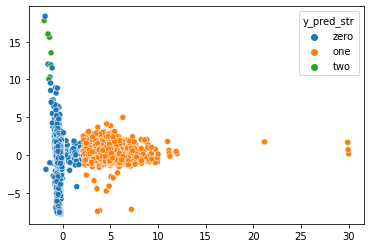

In [ ]:
#Visualize with first 2 components of PCA

start_time = time.time()
pca_num = PCA(n_components=2)
pca_num_data = pca_num.fit_transform(df_test_num_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(pca_num_data[:,0], pca_num_data[:,1], 
                hue=km_3c_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

--- 43.51126527786255 seconds ---
--- 43.616514921188354 seconds ---


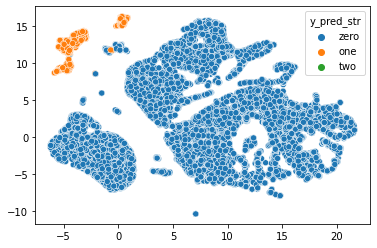

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
umap_num = umap.UMAP(n_neighbors=15,
                     n_components=2,
                     min_dist=0.1,
                     metric='correlation')
umap_num_data = umap_num.fit_transform(df_test_num_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(umap_num_data[:,0], umap_num_data[:,1], 
                hue=km_3c_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Perform K-Means on numerical variables with 6 clusters

start_time = time.time()
km_6c = KMeans(n_clusters=6)
km_6c_pred = km_6c.fit_predict(df_test_num_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

km_6c_pred_df = pd.DataFrame(km_6c_pred, columns=['y_pred'])
km_6c_pred_df['y_pred_str'] = km_6c_pred_df['y_pred'].apply(lambda x: mapping(x))

for i in km_6c_pred_df['y_pred_str'].unique():
    print(km_6c_pred_df['y_pred_str'][(km_6c_pred_df['y_pred_str'] == i)].count())

--- 0.957543134689331 seconds ---
13718
8180
1842
5815
4
7


--- 0.10500216484069824 seconds ---


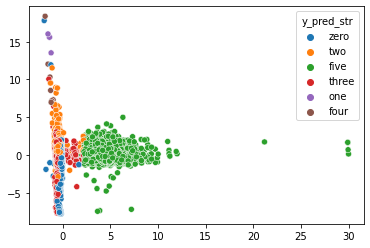

In [ ]:
#Visualize with first 2 components of PCA

start_time = time.time()
sns.scatterplot(pca_num_data[:,0], pca_num_data[:,1], hue=km_6c_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.10197806358337402 seconds ---


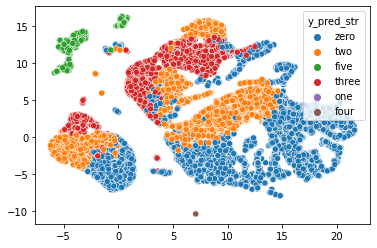

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_num_data[:,0], umap_num_data[:,1], hue=km_6c_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

--- 403.1274118423462 seconds ---
--- 403.2635633945465 seconds ---


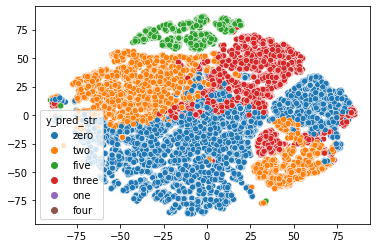

In [ ]:
#Visualize with first 2 components of TSNE

start_time = time.time()
tsne_num = TSNE(n_components=2)
tsne_num_data = tsne_num.fit_transform(df_test_num_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(tsne_num_data[:,0], tsne_num_data[:,1], 
                hue=km_6c_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

# Visualize numerical data with dimensionality reduction

In [ ]:
#Perform PCA on numerical variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
pca_dimred = PCA(n_components=10)
pca_dimred_data = pca_dimred.fit_transform(df_test_num_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
km_4c_pcadimred = KMeans(n_clusters=4, random_state=42)
km_4c_pcadimred_pred = km_4c_pcadimred.fit_predict(pca_dimred_data)

print("--- %s seconds ---" % (time.time() - start_time))

km_4c_pcadimred_pred_df = pd.DataFrame(km_4c_pcadimred_pred, columns=['y_pred'])
km_4c_pcadimred_pred_df['y_pred_str'] = km_4c_pcadimred_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in km_4c_pcadimred_pred_df['y_pred_str'].unique():
    print(km_4c_pcadimred_pred_df['y_pred_str'][(km_4c_pcadimred_pred_df['y_pred_str'] == i)].count())

--- 0.020616769790649414 seconds ---
--- 1.0024182796478271 seconds ---
17312
10408
1840
6


--- 0.11713266372680664 seconds ---


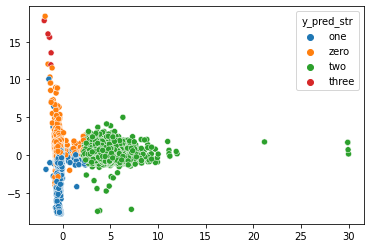

In [ ]:
#Visualize with first 2 components of PCA

start_time = time.time()
sns.scatterplot(pca_dimred_data[:,0], pca_dimred_data[:,1], hue=km_4c_pcadimred_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
umap_num_pca = umap.UMAP(n_neighbors=15,
                     n_components=2,
                     min_dist=0.1,
                     metric='correlation')
umap_num_pca_data = umap_num_pca.fit_transform(pca_dimred_data)
print("--- %s seconds ---" % (time.time() - start_time))

--- 32.368321657180786 seconds ---


--- 0.11586928367614746 seconds ---


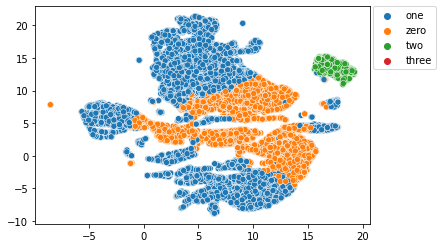

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_num_pca_data[:,0], umap_num_pca_data[:,1], hue=km_4c_pcadimred_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

# Convert categorical data to numerical data with MCA

In [ ]:
#Perform MCA on categorical variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
import prince as pn
mca_test = pn.MCA(n_components=10, n_iter=5, copy=True, check_input=True, 
             engine='sklearn', random_state=123)
mca_test_data = mca_test.fit_transform(df_test_cat)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
km_6c_mca = KMeans(n_clusters=6, random_state=42)
km_6c_mca_pred = km_6c_mca.fit_predict(mca_test_data)
print("--- %s seconds ---" % (time.time() - start_time))

km_6c_mca_pred_df = pd.DataFrame(km_6c_mca_pred, columns=['y_pred'])
km_6c_mca_pred_df['y_pred_str'] = km_6c_mca_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in km_6c_mca_pred_df['y_pred_str'].unique():
    print(km_6c_mca_pred_df['y_pred_str'][(km_6c_mca_pred_df['y_pred_str'] == i)].count())

--- 2.3055918216705322 seconds ---
--- 0.307295560836792 seconds ---
29550
9
4
1
1
1


--- 0.05020308494567871 seconds ---
--- 0.20773077011108398 seconds ---


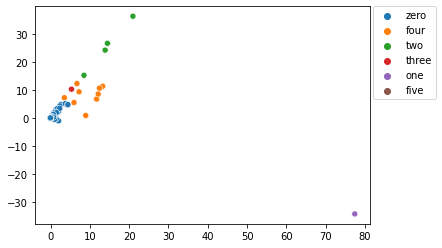

In [ ]:
#Visualize with first 2 components of PCA

start_time = time.time()
pca_mca_test = PCA(n_components=2, random_state=42)
pca_mca_test_data = pca_mca_test.fit_transform(mca_test_data)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(pca_mca_test_data[:,0], pca_mca_test_data[:,1], hue=km_6c_mca_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

--- 41.306538581848145 seconds ---
--- 41.41595482826233 seconds ---


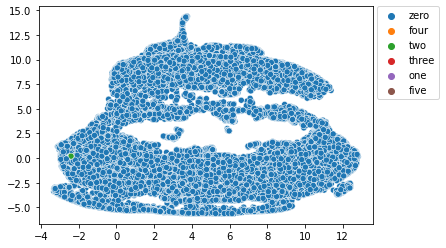

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
umap_mca_test = umap.UMAP(n_neighbors=15,
                      min_dist=0.1,
                      metric='correlation', random_state=42)
umap_mca_test_data = umap_mca_test.fit_transform(mca_test_data)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(umap_mca_test_data[:,0], umap_mca_test_data[:,1], 
                hue=km_6c_mca_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Visualize with first 2 components of TSNE

start_time = time.time()
tsne_mca_test = TSNE(n_components=2, random_state=42)
tsne_mca_test_data = tsne_mca_test.fit_transform(mca_test_data)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(tsne_mca_test_data[:,0], tsne_mca_test_data[:,1], 
                hue=km_6c_mca_pred_df['y_pred_str'])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Scale categorical variables

mca_test_data_scaled = scaler.fit_transform(mca_test_data)

In [ ]:
#Combine scaled MCA-transformed categorical data with scaled numerical data

df_test_2 = pd.concat([pd.DataFrame(df_test_num_scaled), pd.DataFrame(mca_test_data_scaled)], axis=1)
df_test_2.head()

0         1         2  ...         7         8         9
0  1.128300 -1.067596  1.206653  ... -0.018917  0.058982 -0.059005
1 -0.262895  2.275285  1.253850  ... -0.006313  0.007458  0.021480
2 -0.417472 -0.915647 -0.272187  ...  0.073399 -0.063846  0.110195
3  0.046259 -0.459799 -0.224990  ... -0.004699 -0.012661 -0.003693
4  1.282877  0.299946 -0.193526  ... -0.018329 -0.000792 -0.006974

[5 rows x 22 columns]

# Visualize combined data

--- 0.11573433876037598 seconds ---
--- 0.18171286582946777 seconds ---


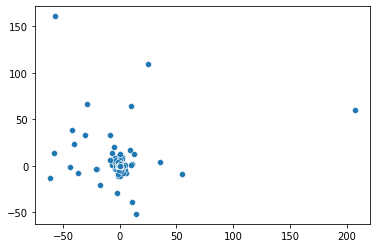

In [ ]:
#Visualize with first 2 components of PCA

start_time = time.time()
pca_2 = PCA(n_components=2, random_state=42)
pca_2_data = pca_2.fit_transform(df_test_2)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(pca_2_data[:,0], pca_2_data[:,1])
print("--- %s seconds ---" % (time.time() - start_time))

--- 55.659672021865845 seconds ---
--- 55.69970083236694 seconds ---


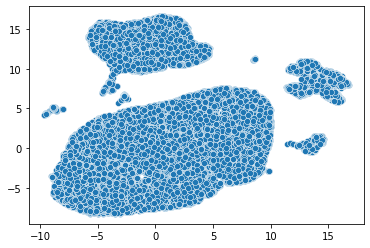

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
umap_2 = umap.UMAP(n_neighbors=30,
                                    n_components=2,
                                    min_dist=0.3,
                                    metric='correlation', random_state=143)
umap_2_data = umap_2.fit_transform(df_test_2)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(umap_2_data[:,0], 
                umap_2_data[:,1])
print("--- %s seconds ---" % (time.time() - start_time))

--- 345.1691164970398 seconds ---
--- 345.22773838043213 seconds ---


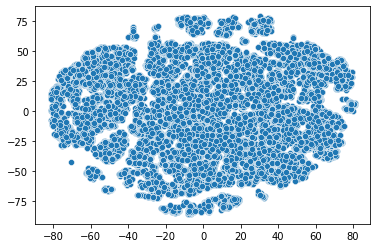

In [ ]:
#Visualize with first 2 components of TSNE

start_time = time.time()
tsne_2 = TSNE(n_components=2, random_state=42)
tsne_2_data = tsne_2.fit_transform(df_test_2)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(tsne_2_data[:,0], tsne_2_data[:,1])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Perform PCA on all variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
km_4c_pca2dimred = KMeans(n_clusters=4, random_state=42)
km_4c_pca2dimred_pred = km_4c_pca2dimred.fit_predict(pca_2_data)

print("--- %s seconds ---" % (time.time() - start_time))

km_4c_pca2dimred_pred_df = pd.DataFrame(km_4c_pca2dimred_pred, columns=['y_pred'])
km_4c_pca2dimred_pred_df['y_pred_str'] = km_4c_pca2dimred_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in km_4c_pca2dimred_pred_df['y_pred_str'].unique():
    print(km_4c_pca2dimred_pred_df['y_pred_str'][(km_4c_pca2dimred_pred_df['y_pred_str'] == i)].count())

--- 0.19376921653747559 seconds ---
29554
7
4
1


--- 0.13333797454833984 seconds ---


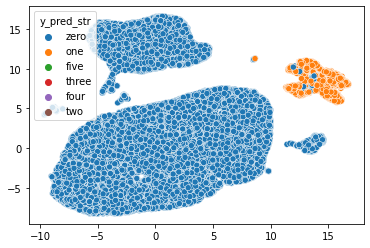

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_2_data[:,0], umap_2_data[:,1], hue=km_6c_pca2dimred_pred_df['y_pred_str'])
print("--- %s seconds ---" % (time.time() - start_time))

# Clustering analysis

## K-means clustering

In [ ]:
#Calculate silhouette score for various numbers of clusters with K-means

start_time = time.time()
umap_2 = umap.UMAP(n_neighbors=30,
                                    n_components=2,
                                    min_dist=0.3,
                                    metric='correlation', random_state=143)
umap_2_data = umap_2.fit_transform(df_test_2)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
for n in range(2, 10):
    km_nc_umap2dimred_temp = KMeans(n_clusters=n, random_state=42)
    km_nc_umap2dimred_temp_pred = km_nc_umap2dimred_temp.fit_predict(umap_2_data)

    km_nc_umap2dimred_temp_pred_df = pd.DataFrame(km_nc_umap2dimred_temp_pred, columns=['y_pred'])
    
    print('For {} clusters:'.format(n))
    print('The silhouette score is {}'.format(silhouette_score(umap_2_data, km_nc_umap2dimred_temp_pred_df['y_pred'], metric='euclidean')))
    print("--- %s seconds ---" % (time.time() - start_time))
    print()

--- 54.2536039352417 seconds ---
For 2 clusters:
The silhouette score is 0.4033220112323761
--- 12.975350618362427 seconds ---

For 3 clusters:
The silhouette score is 0.49826639890670776
--- 25.652677059173584 seconds ---

For 4 clusters:
The silhouette score is 0.4597993493080139
--- 38.401432037353516 seconds ---

For 5 clusters:
The silhouette score is 0.43924134969711304
--- 51.1495406627655 seconds ---

For 6 clusters:
The silhouette score is 0.4597831666469574
--- 63.880581855773926 seconds ---

For 7 clusters:
The silhouette score is 0.45950815081596375
--- 76.76318192481995 seconds ---

For 8 clusters:
The silhouette score is 0.417730450630188
--- 89.61376643180847 seconds ---

For 9 clusters:
The silhouette score is 0.4111974835395813
--- 102.47578930854797 seconds ---



In [ ]:
#Perform K-Means on resulting components with optimal number of clusters

start_time = time.time()
km_3c_umap2dimred = KMeans(n_clusters=3, random_state=3)
km_3c_umap2dimred_pred = km_3c_umap2dimred.fit_predict(umap_2_data)
print("--- %s seconds ---" % (time.time() - start_time))

km_3c_umap2dimred_pred_df = pd.DataFrame(km_3c_umap2dimred_pred, columns=['y_pred'])
km_3c_umap2dimred_pred_df['y_pred_str'] = km_3c_umap2dimred_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in km_3c_umap2dimred_pred_df['y_pred_str'].unique():
    print(km_3c_umap2dimred_pred_df['y_pred_str'][(km_3c_umap2dimred_pred_df['y_pred_str'] == i)].count())

--- 0.19362401962280273 seconds ---
12039
11166
6361


--- 0.11869645118713379 seconds ---


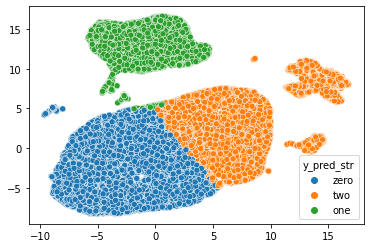

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_2_data[:,0], umap_2_data[:,1], hue=km_3c_umap2dimred_pred_df['y_pred_str'])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_2_data, km_3c_umap2dimred_pred_df['y_pred'], metric='euclidean')))

The silhouette score is 0.498276948928833


In [ ]:
#Perform K-Means on resulting components with optimal number of clusters

start_time = time.time()
km_4c_umap2dimred = KMeans(n_clusters=4, random_state=3)
km_4c_umap2dimred_pred = km_4c_umap2dimred.fit_predict(umap_2_data)
print("--- %s seconds ---" % (time.time() - start_time))

km_4c_umap2dimred_pred_df = pd.DataFrame(km_4c_umap2dimred_pred, columns=['y_pred'])
km_4c_umap2dimred_pred_df['y_pred_str'] = km_4c_umap2dimred_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in km_4c_umap2dimred_pred_df['y_pred_str'].unique():
    print(km_4c_umap2dimred_pred_df['y_pred_str'][(km_4c_umap2dimred_pred_df['y_pred_str'] == i)].count())

--- 0.43332672119140625 seconds ---
9118
9674
6259
4515


--- 0.10143685340881348 seconds ---


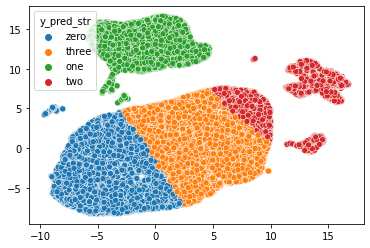

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_2_data[:,0], umap_2_data[:,1], hue=km_4c_umap2dimred_pred_df['y_pred_str'])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_2_data, km_4c_umap2dimred_pred_df['y_pred'], metric='euclidean')))

The silhouette score is 0.4589085280895233


## Hierarchical clustering

In [ ]:
#Calculate silhouette score for various numbers of clusters with hierarchical clustering

start_time = time.time()
for n in range(2, 10):
    agg_nc_umap2dimred_temp = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=n,
                                              compute_full_tree=False)
    agg_nc_umap2dimred_temp_pred = agg_nc_umap2dimred_temp.fit_predict(umap_2_data)

    agg_nc_umap2dimred_temp_pred_df = pd.DataFrame(agg_nc_umap2dimred_temp_pred, columns=['y_pred'])
    
    print('For {} clusters:'.format(n))
    print('The silhouette score is {}'.format(silhouette_score(umap_2_data, agg_nc_umap2dimred_temp_pred_df['y_pred'], metric='euclidean')))
    print("--- %s seconds ---" % (time.time() - start_time))
    print()

For 2 clusters:
The silhouette score is 0.32173413038253784
--- 54.307013750076294 seconds ---

For 3 clusters:
The silhouette score is 0.3876321315765381
--- 94.7329306602478 seconds ---

For 4 clusters:
The silhouette score is 0.3521754741668701
--- 134.62756943702698 seconds ---

For 5 clusters:
The silhouette score is 0.363471120595932
--- 174.59777927398682 seconds ---

For 6 clusters:
The silhouette score is 0.31116899847984314
--- 214.23334622383118 seconds ---

For 7 clusters:
The silhouette score is 0.2966747581958771
--- 253.84240198135376 seconds ---

For 8 clusters:
The silhouette score is 0.2627886235713959
--- 294.0626051425934 seconds ---

For 9 clusters:
The silhouette score is 0.23551501333713531
--- 334.3510231971741 seconds ---



In [ ]:
#Perform hierarchical clustering on resulting components with optimal number of clusters

start_time = time.time()
agg_2c_umap2dimred = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

agg_2c_umap2dimred_pred = agg_2c_umap2dimred.fit_predict(umap_2_data)
print("--- %s seconds ---" % (time.time() - start_time))

agg_2c_umap2dimred_pred_df = pd.DataFrame(agg_2c_umap2dimred_pred, columns=['y_pred'])
agg_2c_umap2dimred_pred_df['y_pred_str'] = agg_2c_umap2dimred_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in agg_2c_umap2dimred_pred_df['y_pred_str'].unique():
    print(agg_2c_umap2dimred_pred_df['y_pred_str'][(agg_2c_umap2dimred_pred_df['y_pred_str'] == i)].count())

--- 27.135425090789795 seconds ---
15577
13989


--- 0.10542488098144531 seconds ---


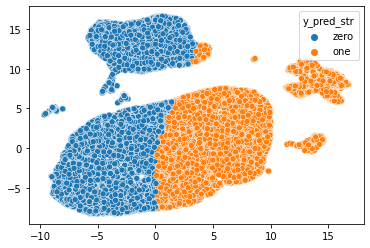

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_2_data[:,0], umap_2_data[:,1], hue=agg_2c_umap2dimred_pred_df['y_pred_str'])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_2_data, agg_2c_umap2dimred_pred_df['y_pred'], metric='euclidean')))

The silhouette score is 0.32173413038253784


In [ ]:
#Perform hierarchical clustering on resulting components with optimal number of clusters

start_time = time.time()
agg_3c_umap2dimred = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3)

agg_3c_umap2dimred_pred = agg_2c_umap2dimred.fit_predict(umap_2_data)
print("--- %s seconds ---" % (time.time() - start_time))

agg_3c_umap2dimred_pred_df = pd.DataFrame(agg_3c_umap2dimred_pred, columns=['y_pred'])
agg_3c_umap2dimred_pred_df['y_pred_str'] = agg_3c_umap2dimred_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in agg_3c_umap2dimred_pred_df['y_pred_str'].unique():
    print(agg_3c_umap2dimred_pred_df['y_pred_str'][(agg_3c_umap2dimred_pred_df['y_pred_str'] == i)].count())

--- 26.72050166130066 seconds ---
15577
13989


--- 0.22994518280029297 seconds ---


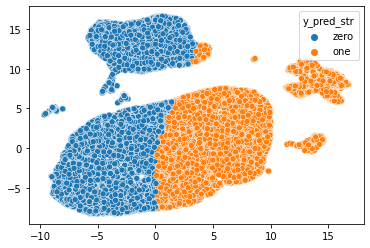

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_2_data[:,0], umap_2_data[:,1], hue=agg_3c_umap2dimred_pred_df['y_pred_str'])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_2_data, agg_3c_umap2dimred_pred_df['y_pred'], metric='euclidean')))

The silhouette score is 0.32173413038253784


## DBSCAN clustering

In [ ]:
#Calculate silhouette score for various values of epsilon with DBSCAN

start_time = time.time()
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    dbs_umap2dimred_temp = DBSCAN(eps=i, min_samples=5)

    dbs_umap2dimred_temp_pred = dbs_umap2dimred_temp.fit_predict(umap_2_data)

    dbs_umap2dimred_temp_pred_df = pd.DataFrame(dbs_umap2dimred_temp_pred, columns=['y_pred'])
    
    print('For an epsilon of {}'.format(i))
    print('The silhouette score is {}'.format(silhouette_score(umap_2_data, dbs_umap2dimred_temp_pred_df['y_pred'], metric='euclidean')))
    print("--- %s seconds ---" % (time.time() - start_time))
    print()

For an epsilon of 0.1
The silhouette score is 0.03987434506416321
--- 12.857027292251587 seconds ---

For an epsilon of 0.2
The silhouette score is -0.4128628671169281
--- 26.812808752059937 seconds ---

For an epsilon of 0.3
The silhouette score is -0.040679365396499634
--- 40.72009611129761 seconds ---

For an epsilon of 0.4
The silhouette score is 0.006115814670920372
--- 54.8415424823761 seconds ---

For an epsilon of 0.5
The silhouette score is 0.01136491633951664
--- 68.91466283798218 seconds ---

For an epsilon of 0.6
The silhouette score is 0.08512333780527115
--- 82.99325823783875 seconds ---

For an epsilon of 0.7
The silhouette score is 0.08512333780527115
--- 97.25244092941284 seconds ---

For an epsilon of 0.8
The silhouette score is 0.08512333780527115
--- 111.79155540466309 seconds ---

For an epsilon of 0.9
The silhouette score is 0.08512333780527115
--- 126.06000971794128 seconds ---

For an epsilon of 1
The silhouette score is 0.08512333780527115
--- 140.6349716186523

In [ ]:
#Perform DBSCAN on resulting components with optimal epsilon

start_time = time.time()
dbs_umap2dimred = DBSCAN(eps=0.3, min_samples=5)

dbs_umap2dimred_pred = dbs_umap2dimred.fit_predict(umap_2_data)
print("--- %s seconds ---" % (time.time() - start_time))

dbs_umap2dimred_pred_df = pd.DataFrame(dbs_umap2dimred_pred, columns=['y_pred'])
dbs_umap2dimred_pred_df['y_pred_str'] = dbs_umap2dimred_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in dbs_umap2dimred_pred_df['y_pred_str'].unique():
    print(dbs_umap2dimred_pred_df['y_pred_str'][(dbs_umap2dimred_pred_df['y_pred_str'] == i)].count())

--- 0.3255038261413574 seconds ---
20688
5965
1999
173
423
8
0


--- 0.1057891845703125 seconds ---


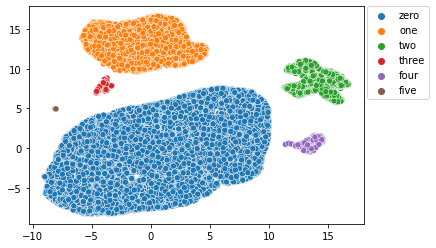

In [ ]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_2_data[:,0], umap_2_data[:,1], hue=dbs_umap2dimred_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_2_data, dbs_umap2dimred_pred_df['y_pred'], metric='euclidean')))

The silhouette score is -0.040679365396499634


### K-means clustering with 3 clusters determined to be optimal clustering method via silhouette score, DBSCAN with epsilon 0.3 determined to be optimal clustering method via visual analysis of 2-dimensional visualization. Both with be utilized for final analysis.

# Repeat analysis with full dataset

In [16]:
#Split dataset into numerical and categorical variables

df_num = df_clean[['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT']].copy()
df_cat = df_clean.drop(['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT'], axis=1)

In [17]:
#Scale numerical variables

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)

In [18]:
#Perform MCA on categorical variables for dimensionality reduction

start_time = time.time()
mca = pn.MCA(n_components=10, n_iter=5, copy=True, check_input=True, 
             engine='sklearn')
df_cat_mca = mca.fit_transform(df_cat)
print("--- %s seconds ---" % (time.time() - start_time))

--- 25.80526113510132 seconds ---


In [19]:
#Scale categorical variables and combine with numerical variables

df_cat_mca_scaled = scaler.fit_transform(df_cat_mca)

df_full = pd.concat([pd.DataFrame(df_num_scaled), pd.DataFrame(df_cat_mca_scaled)], axis=1)

In [20]:
# pca_full = PCA(n_components=2)
# pca_full_data = pca_full.fit_transform(df_full)

In [23]:
umap_full = umap.UMAP(n_neighbors=10,
                                    n_components=3,
                                    min_dist=0.4,
                                    metric='correlation',
                                    low_memory=True)
umap_full_data = umap_full.fit_transform(df_full)

--- 0.09713029861450195 seconds ---


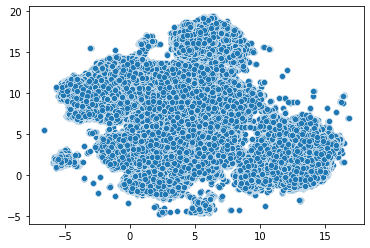

In [24]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_full_data[:,0], umap_full_data[:,1])
print("--- %s seconds ---" % (time.time() - start_time))

In [31]:
#Perform K-Means on resulting components with optimal number of clusters

start_time = time.time()
km_4c_full = KMeans(n_clusters=4)
km_4c_full_pred = km_4c_full.fit_predict(umap_full_data)
print("--- %s seconds ---" % (time.time() - start_time))

km_4c_full_pred_df = pd.DataFrame(km_4c_full_pred, columns=['y_pred'])
km_4c_full_pred_df['y_pred_str'] = km_4c_full_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in km_4c_full_pred_df['y_pred_str'].unique():
    print(km_4c_full_pred_df['y_pred_str'][(km_4c_full_pred_df['y_pred_str'] == i)].count())

--- 4.424315452575684 seconds ---
97551
71565
50782
75760


--- 0.5406622886657715 seconds ---


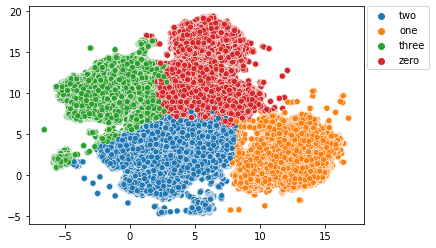

In [32]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_full_data[:,0], umap_full_data[:,1], hue=km_4c_full_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_full_data, km_3c_full_pred_df['y_pred'], metric='euclidean')))

In [35]:
#Perform DBSCAN on resulting components with optimal epsilon

start_time = time.time()
dbs_full = DBSCAN(eps=0.2, min_samples=1)
dbs_full_pred = dbs_full.fit_predict(umap_full_data)
print("--- %s seconds ---" % (time.time() - start_time))

dbs_full_pred_df = pd.DataFrame(dbs_full_pred, columns=['y_pred'])
dbs_full_pred_df['y_pred_str'] = dbs_full_pred_df['y_pred'].apply(lambda x: mapping(x))
for i in dbs_full_pred_df['y_pred_str'].unique():
    print(dbs_full_pred_df['y_pred_str'][(dbs_full_pred_df['y_pred_str'] == i)].count())

--- 6.407593011856079 seconds ---
122075
66549
33077
8267
16868
19293
0


--- 0.4966392517089844 seconds ---


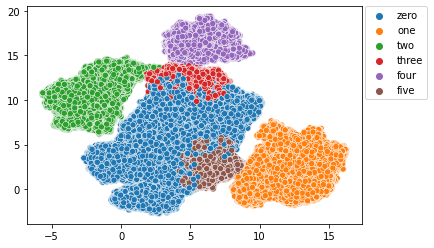

In [36]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_full_data[:,0], umap_full_data[:,1], hue=dbs_full_pred_df['y_pred_str'])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_full_data, dbs_full_pred_df['y_pred'], metric='euclidean')))

# Analyze clusters

In [49]:
df_clean['Cluster'] = km_4c_full_pred

In [48]:
km_4c_full_pred

array([2, 1, 1, ..., 0, 0, 1], dtype=int32)

In [39]:
categorical = list(df_clean.select_dtypes(include='object').columns)
categorical.append('AREA')
categorical.append('RES_AREA')
categorical.append('BUS_AREA')

df_clean = pd.get_dummies(data=df_clean, columns=categorical)

In [50]:
df_clean_0 = df_clean[(df_clean['Cluster'] == 0)]
df_clean_1 = df_clean[(df_clean['Cluster'] == 1)]
df_clean_2 = df_clean[(df_clean['Cluster'] == 2)]
df_clean_3 = df_clean[(df_clean['Cluster'] == 3)]

In [ ]:
for col in df_clean.select_dtypes(exclude='object').columns:
    print(col)
    print(stats.f_oneway(df_clean_0[col], df_clean_1[col], df_clean_2[col], df_clean_3[col]))
    print('___________________________')

In [60]:
results = pd.DataFrame()
results['Comp'] = ['0vs1', '0vs2', '0vs3', '1vs2', '1vs3', '2vs3']
p_values = pd.DataFrame()
p_values['Comp'] = ['0vs1', '0vs2', '0vs3', '1vs2', '1vs3', '2vs3']

for col in df_clean.select_dtypes(exclude='object').columns:
    tukey = pairwise_tukeyhsd(endog = df_clean[col],
                          groups = df_clean['Cluster'],
                          alpha=0.001)
    results[col] = tukey.reject
    p_values[col] = tukey.pvalues

In [63]:
results.replace(to_replace=True, value=1, inplace=True)
results.replace(to_replace=False, value=0, inplace=True)

In [65]:
results_significant = results.copy()
results_significant.drop(['Comp', 'Cluster'], axis=1, inplace=True)

for col in results_significant.columns:   
    if results_significant[col].sum() == 0:
        results_significant.drop(col, axis=1, inplace=True)
        
sig_features = list(results_significant.columns)

In [66]:
cluster_means = df_clean.groupby(['Cluster']).mean()
cluster_means

CONTACT_HOUR  NAME_VERIFIED_I  ...  BUS_AREA_2  BUS_AREA_3
Cluster                                 ...                        
0           15.232247         0.297954  ...    0.000000    0.000000
1           14.693314         0.423377  ...    0.000000    0.000196
2           15.526463         0.398489  ...    0.000164    0.000349
3           12.875842         0.404415  ...    0.005908    0.013725

[4 rows x 401 columns]

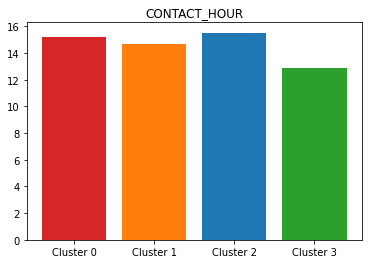

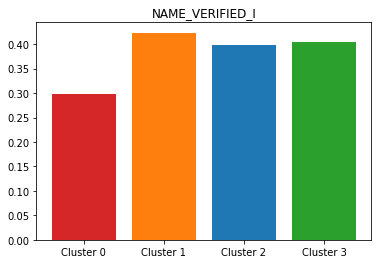

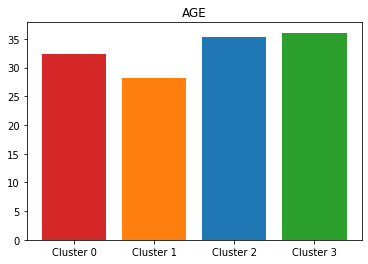

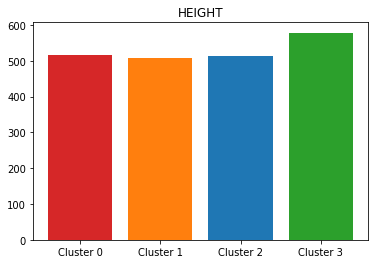

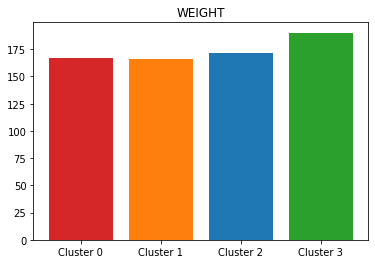

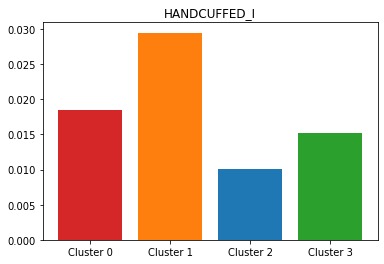

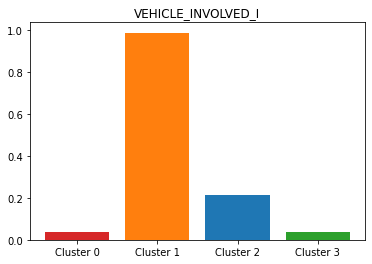

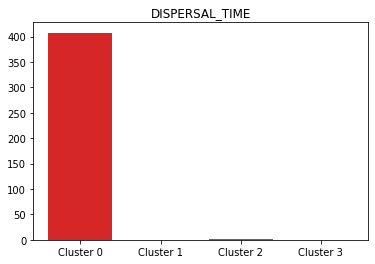

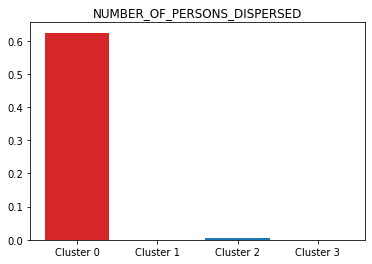

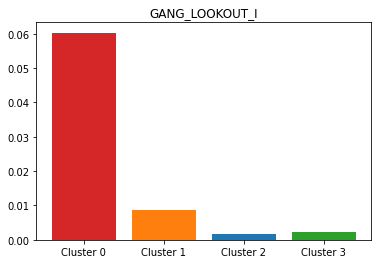

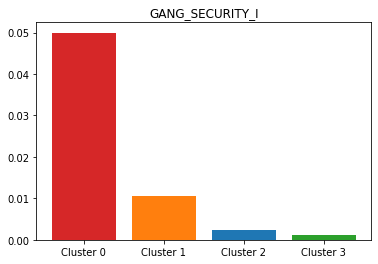

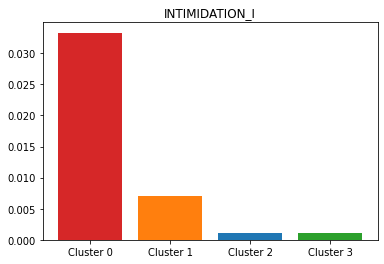

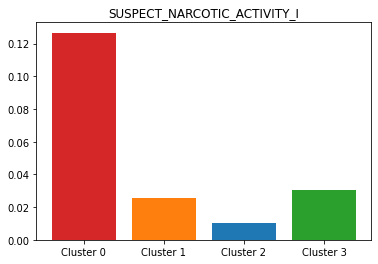

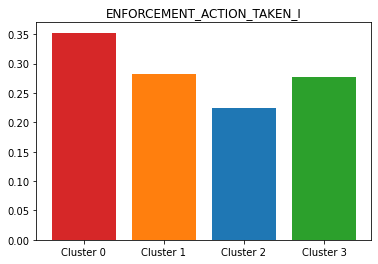

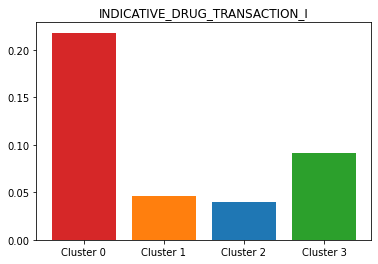

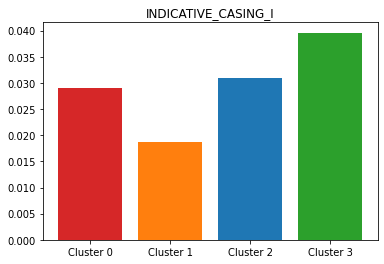

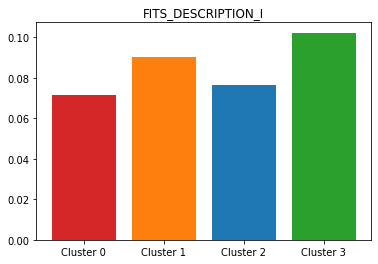

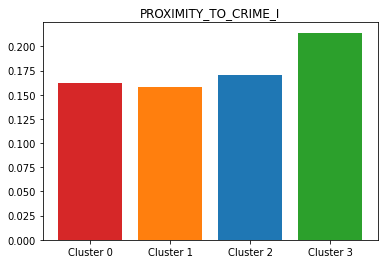

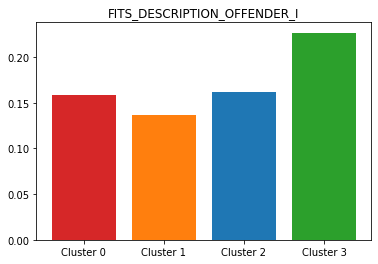

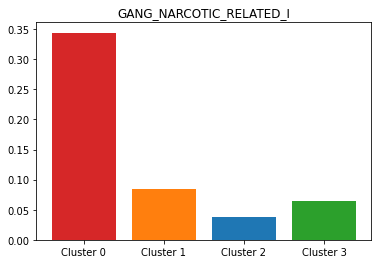

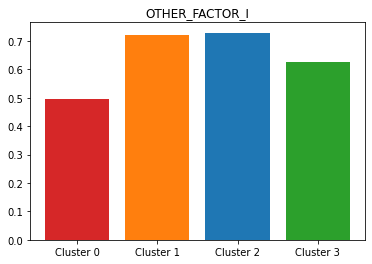

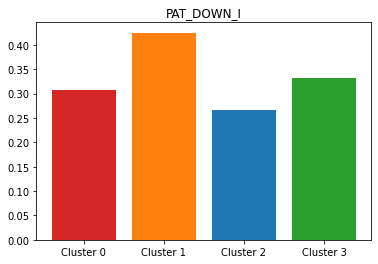

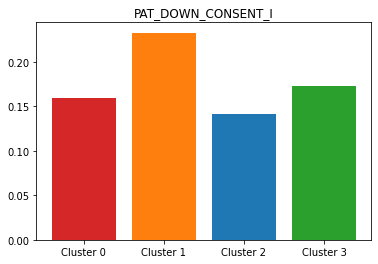

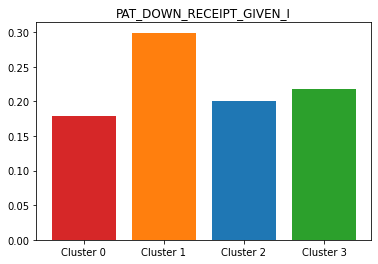

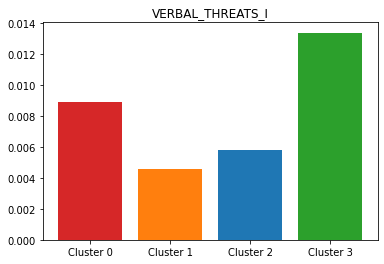

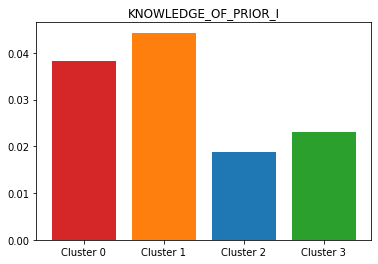

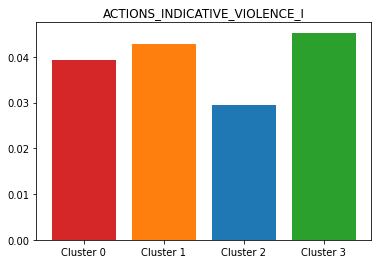

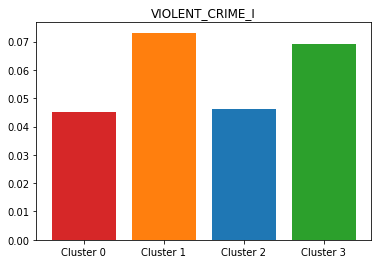

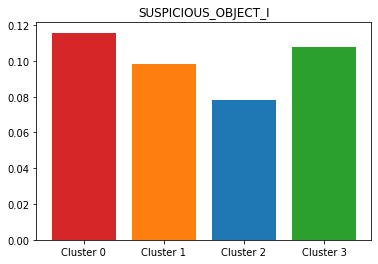

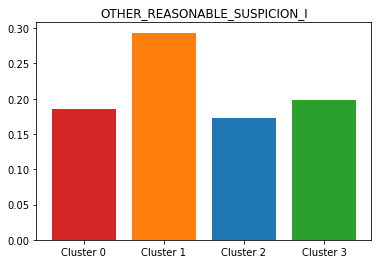

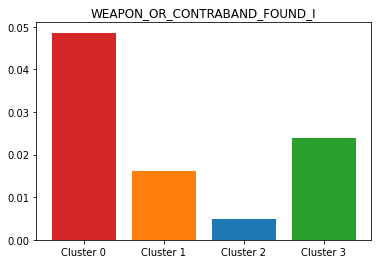

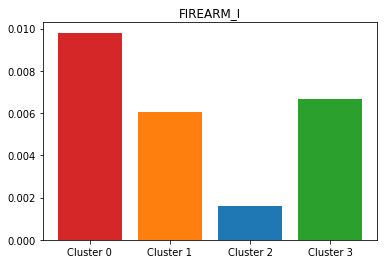

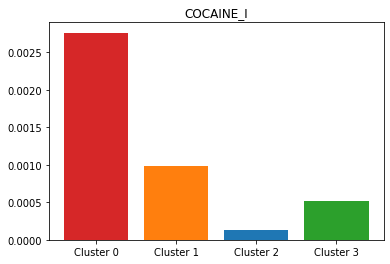

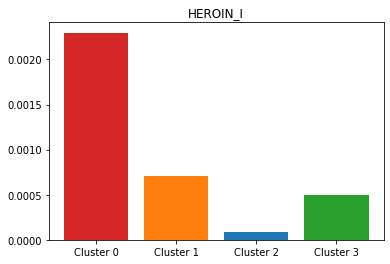

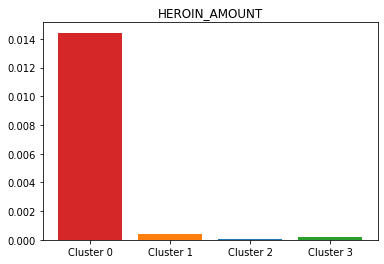

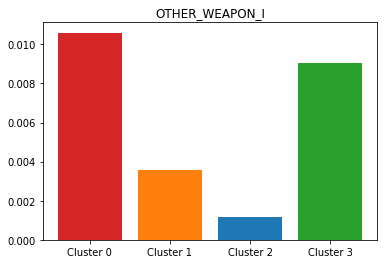

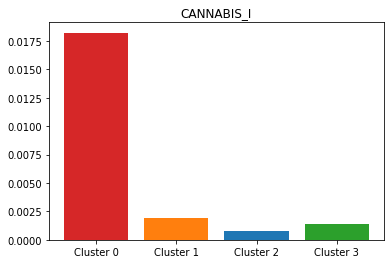

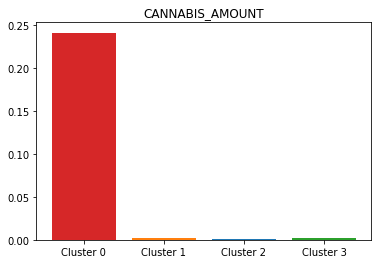

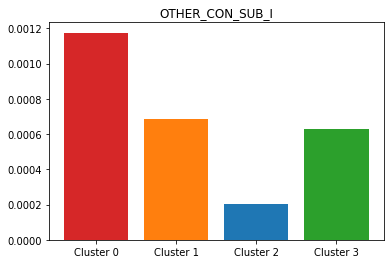

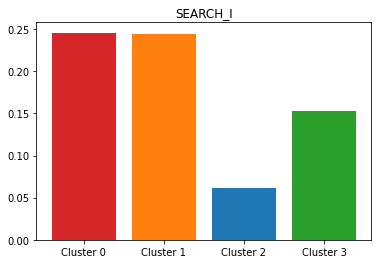

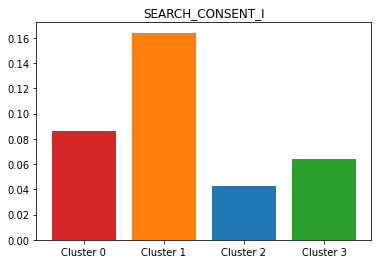

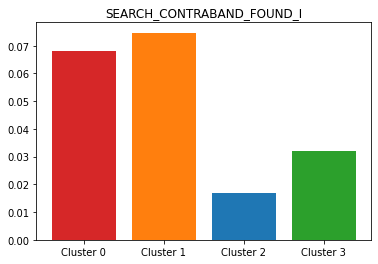

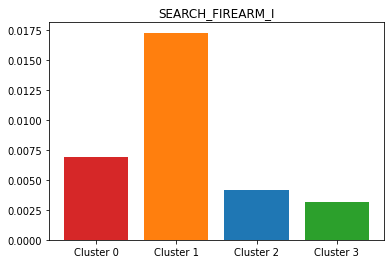

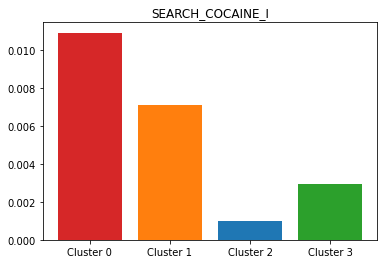

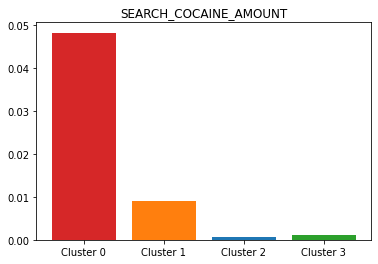

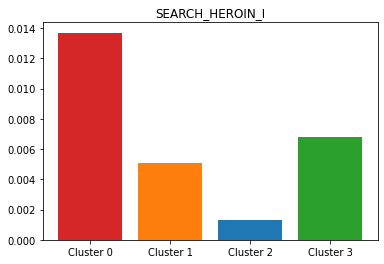

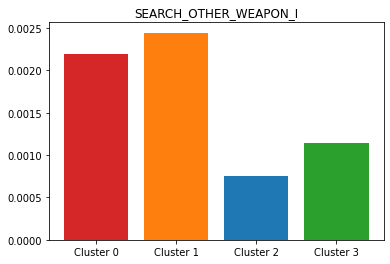

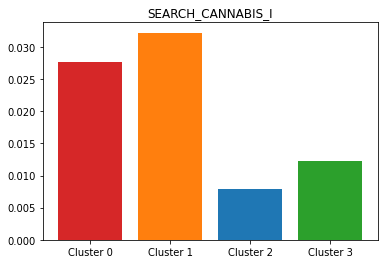

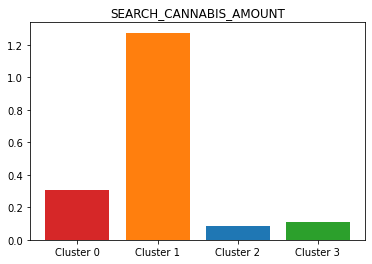

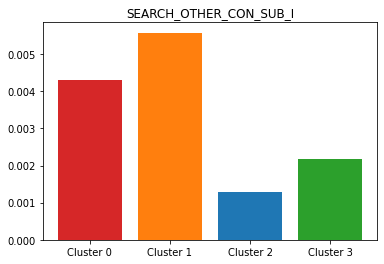

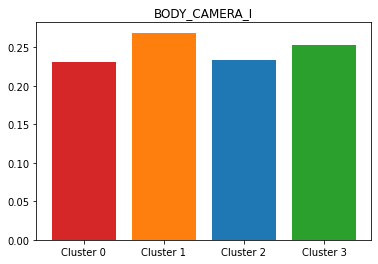

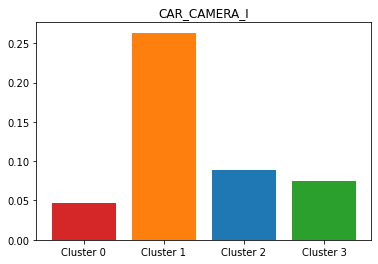

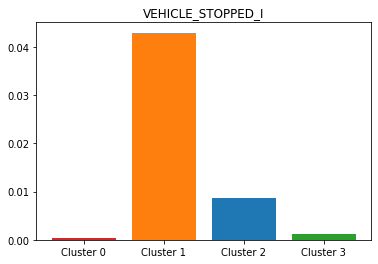

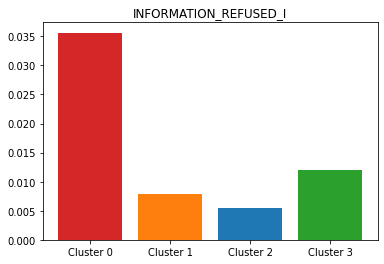

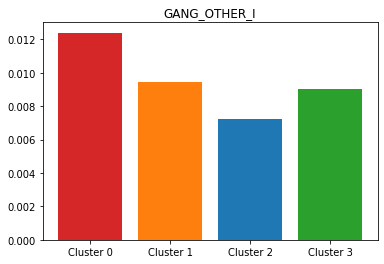

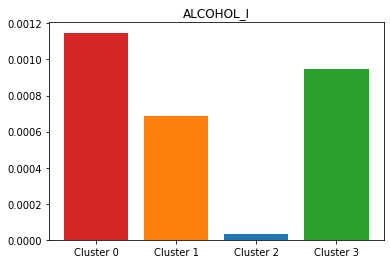

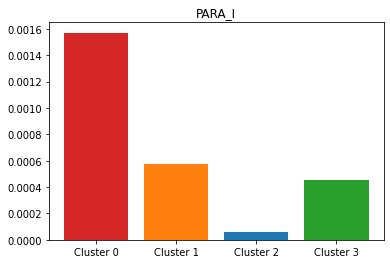

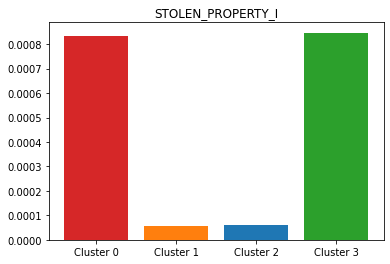

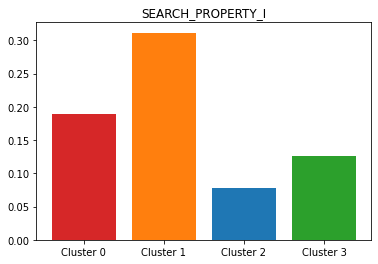

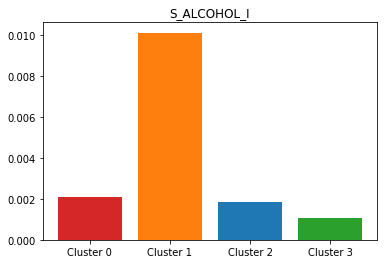

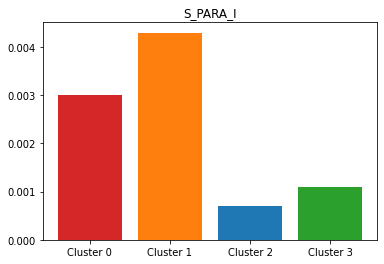

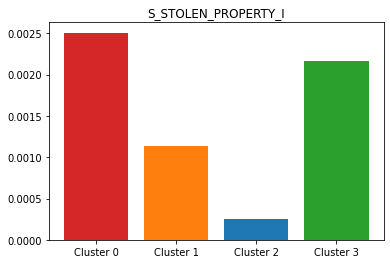

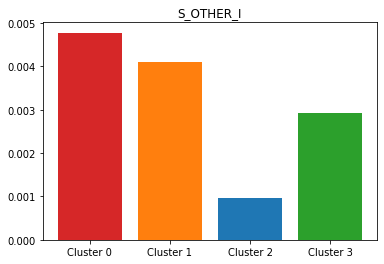

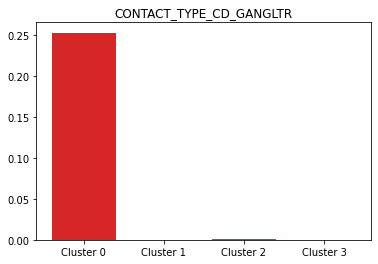

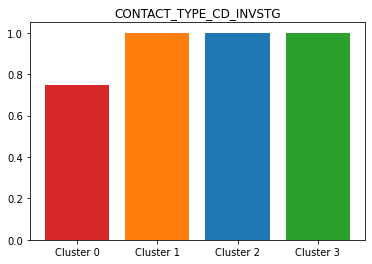

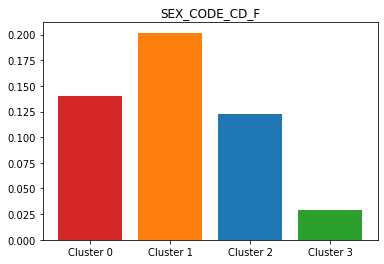

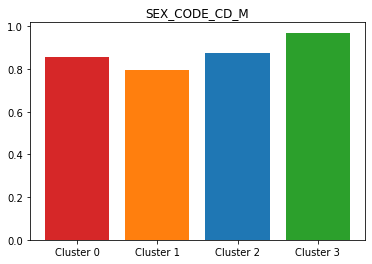

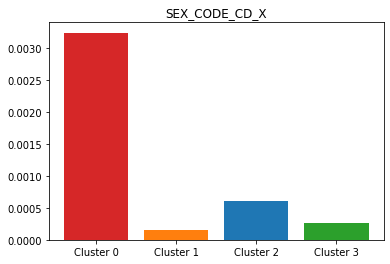

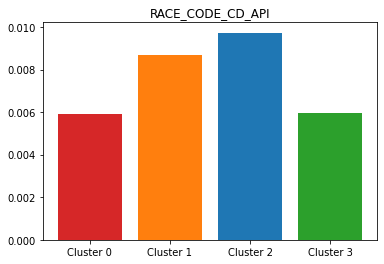

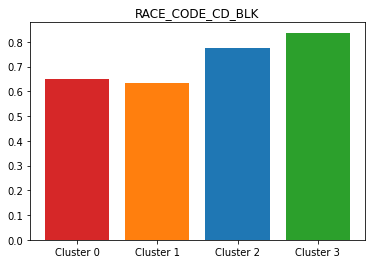

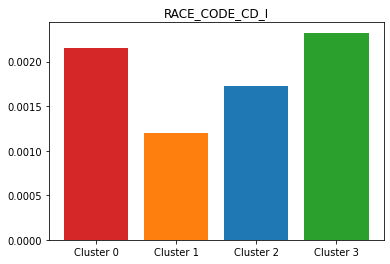

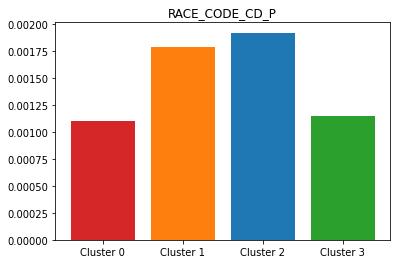

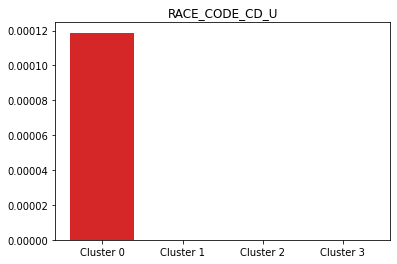

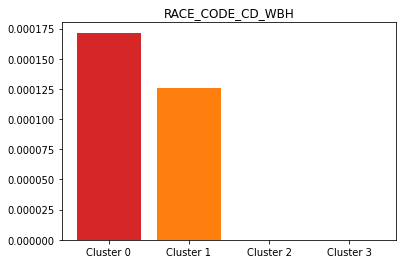

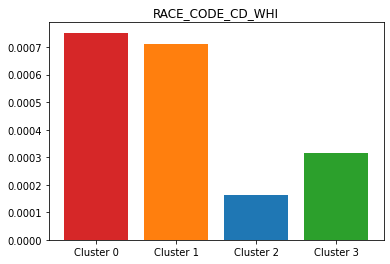

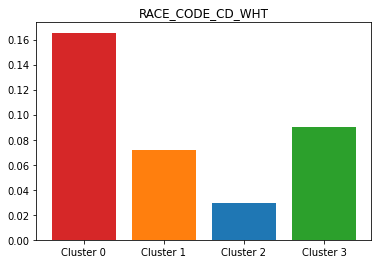

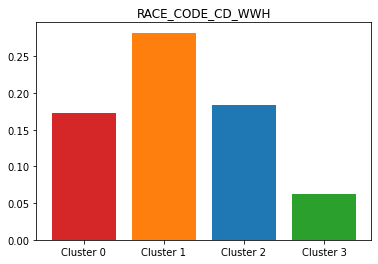

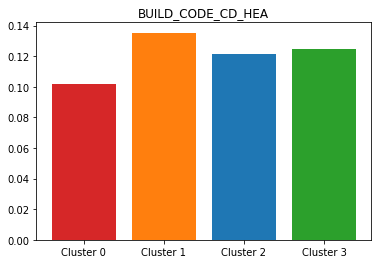

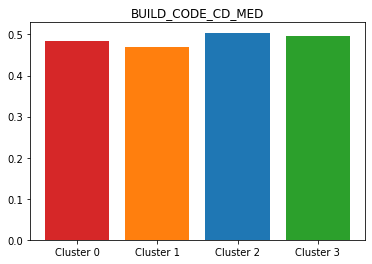

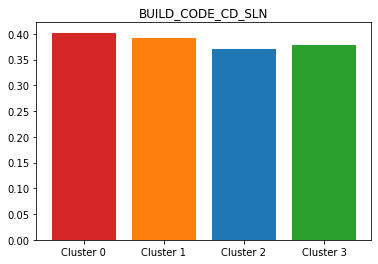

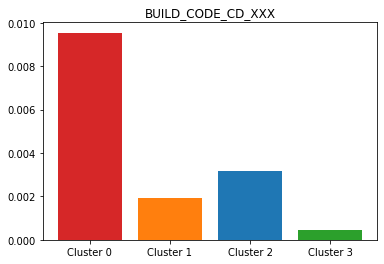

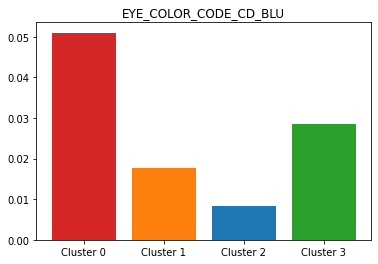

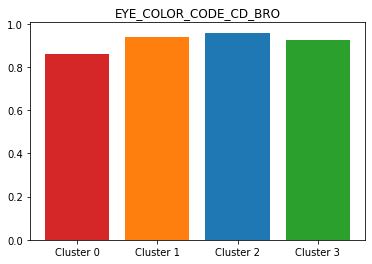

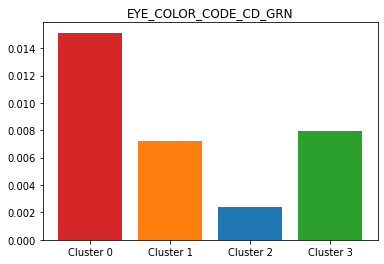

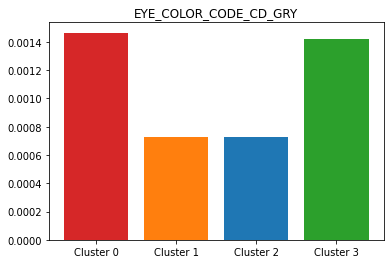

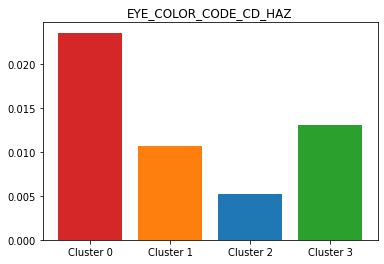

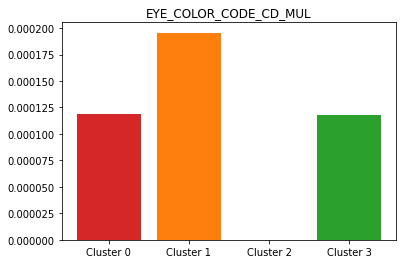

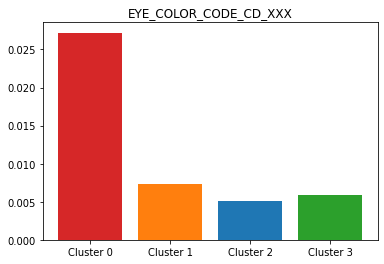

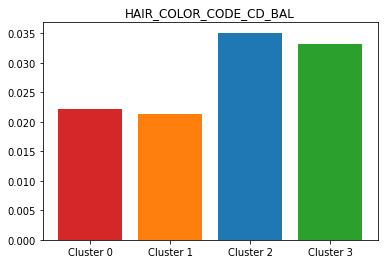

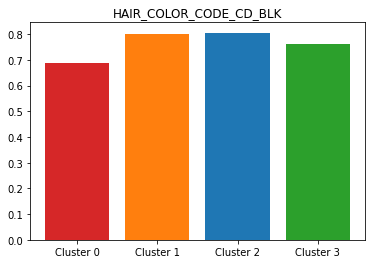

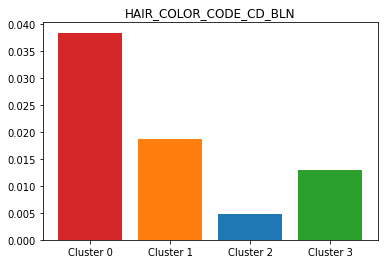

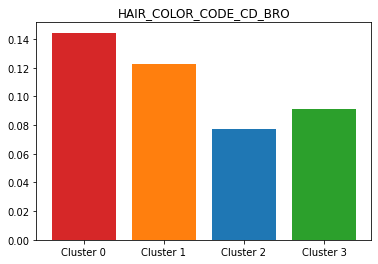

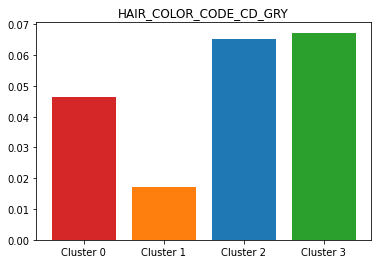

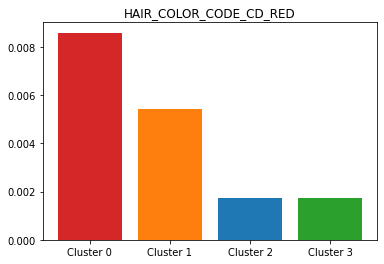

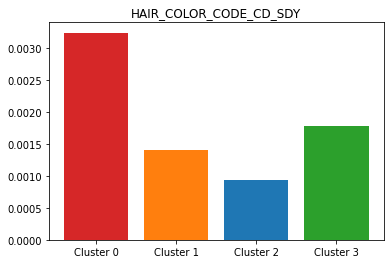

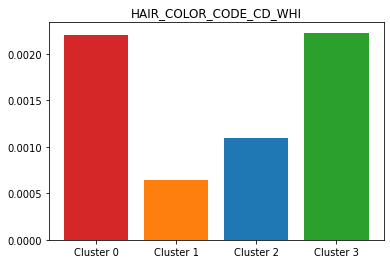

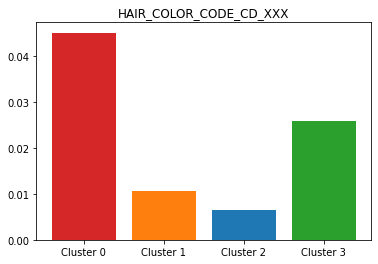

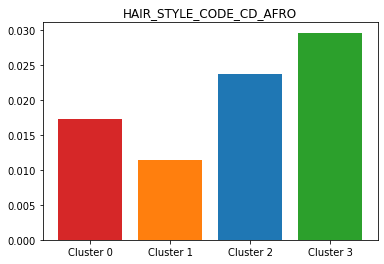

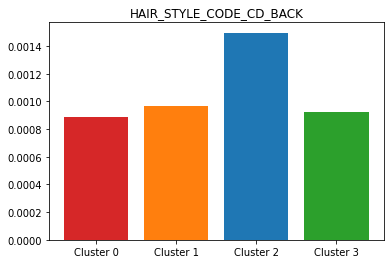

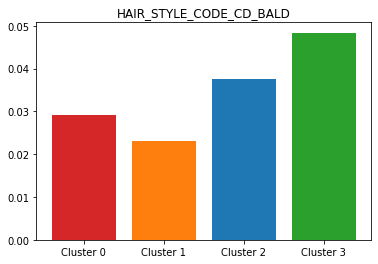

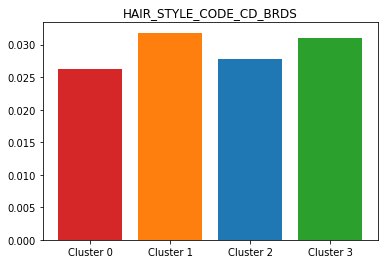

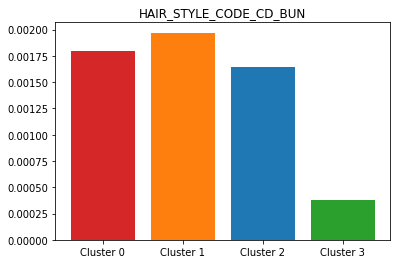

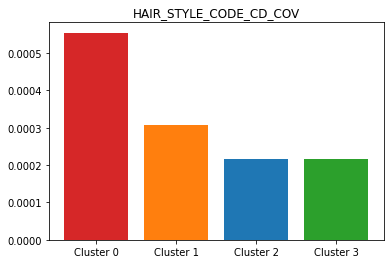

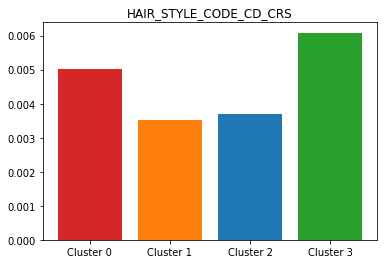

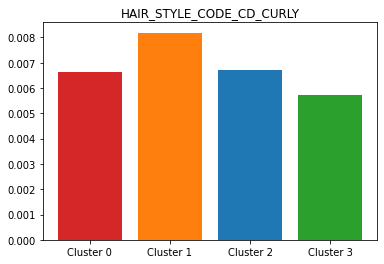

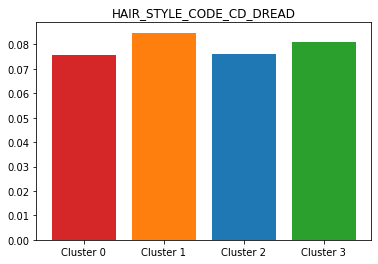

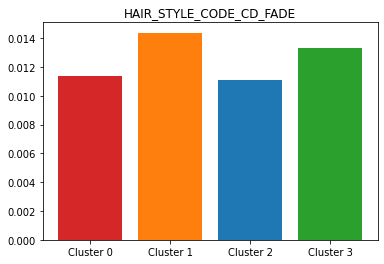

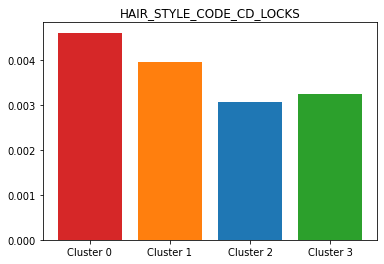

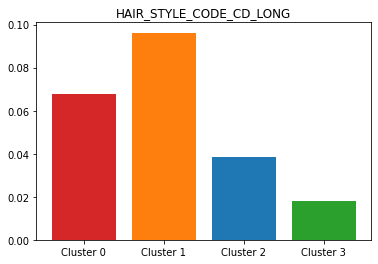

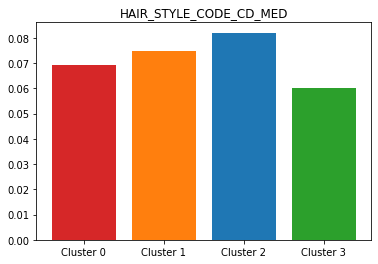

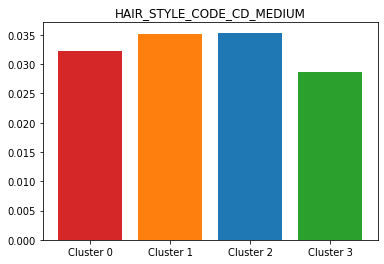

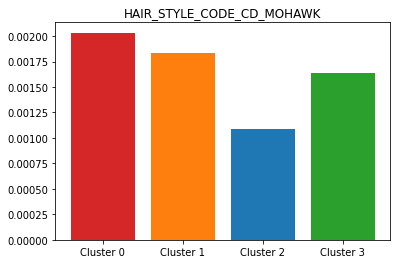

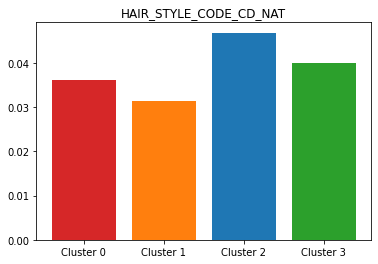

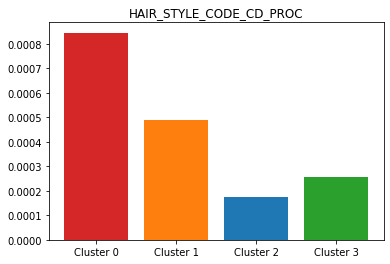

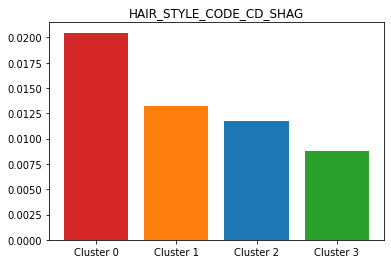

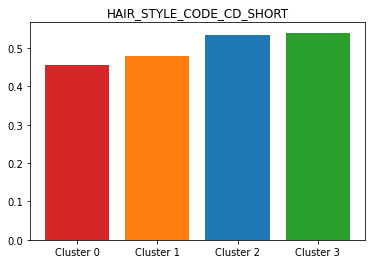

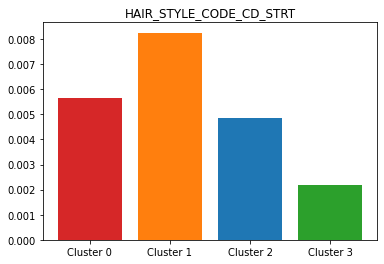

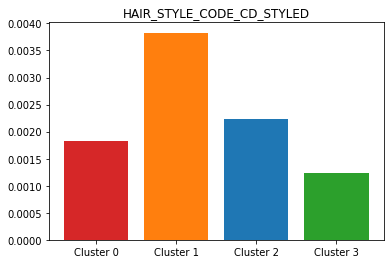

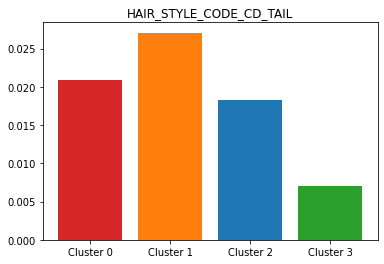

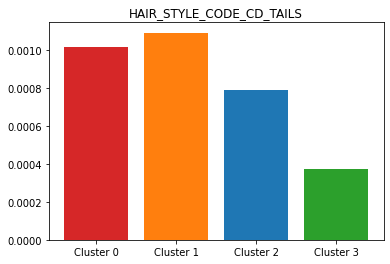

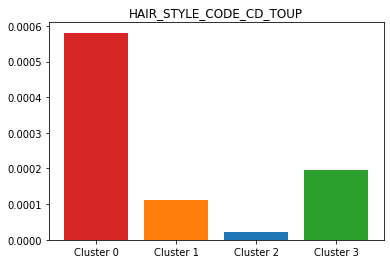

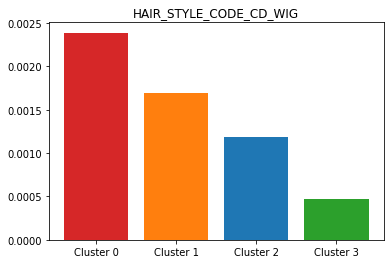

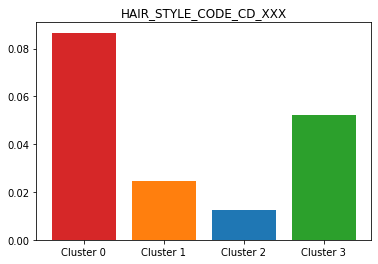

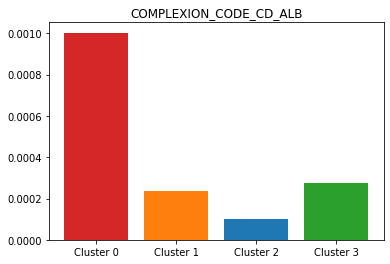

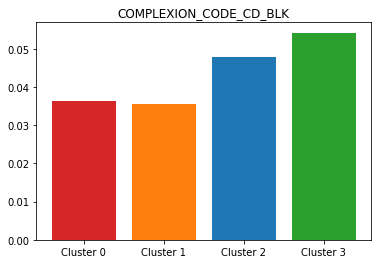

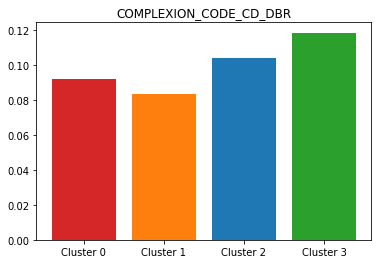

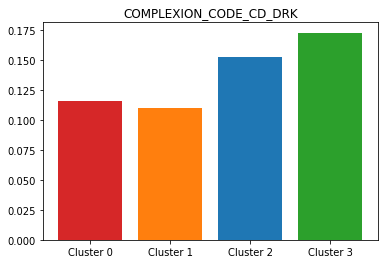

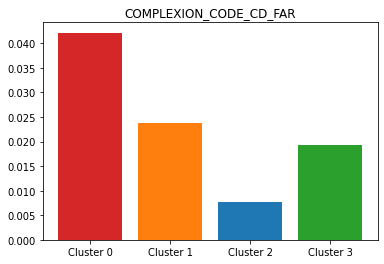

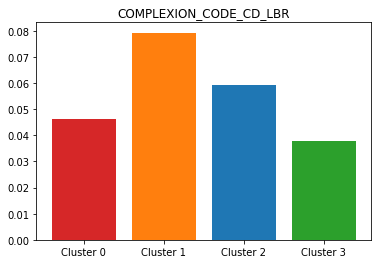

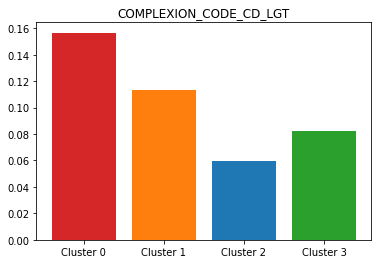

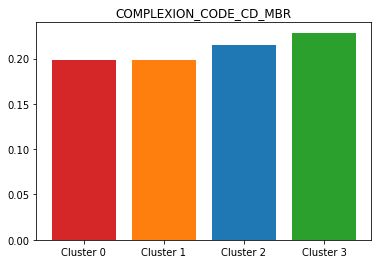

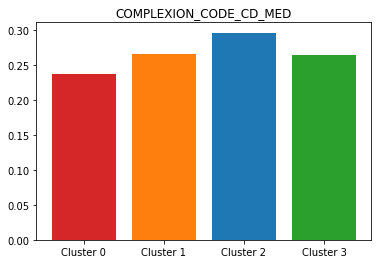

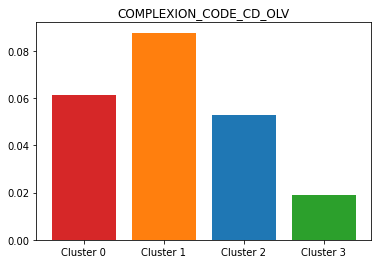

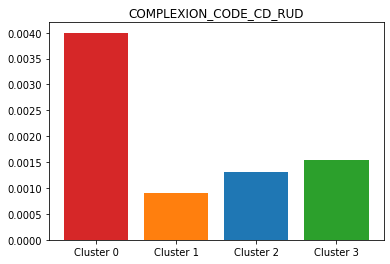

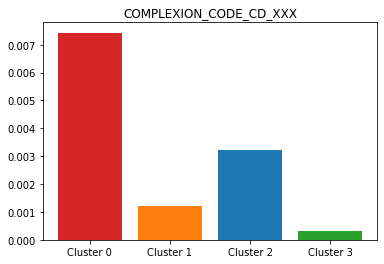

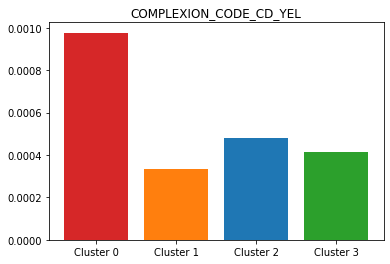

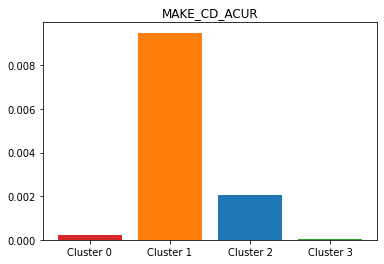

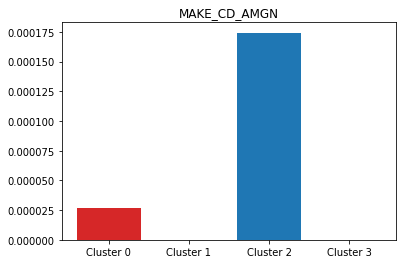

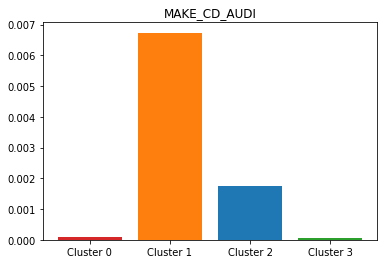

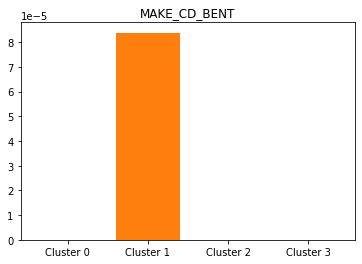

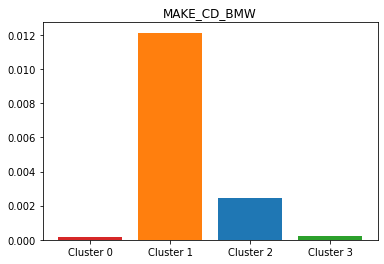

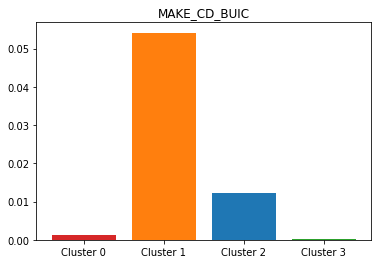

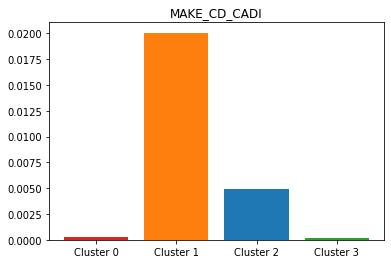

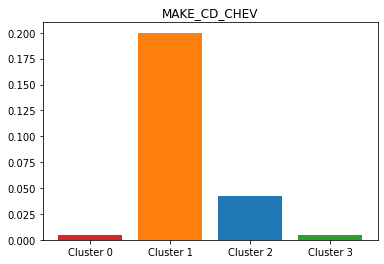

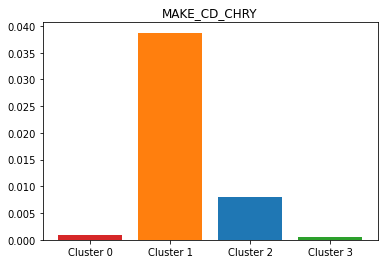

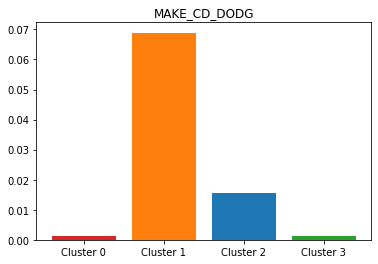

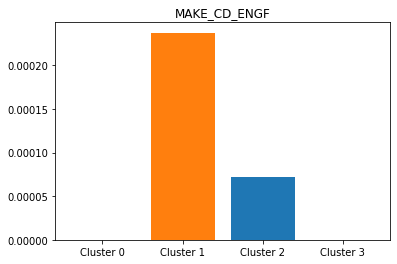

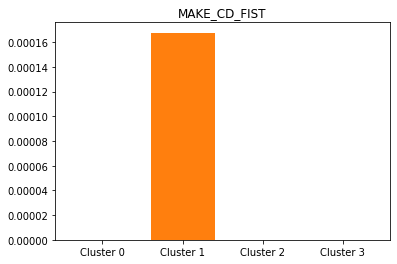

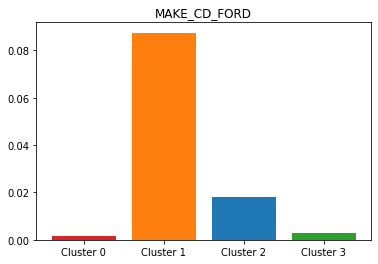

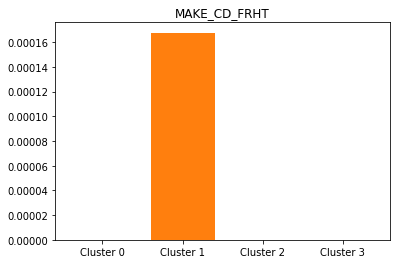

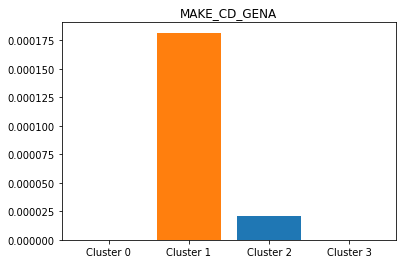

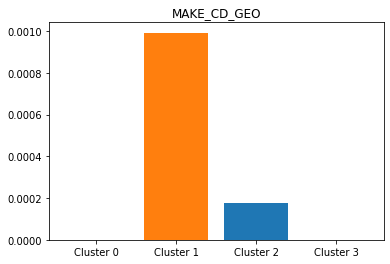

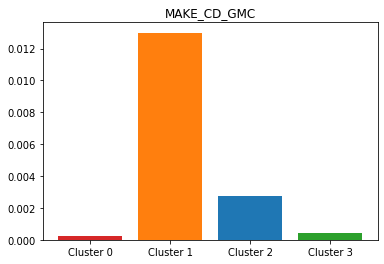

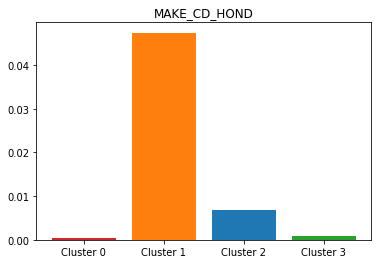

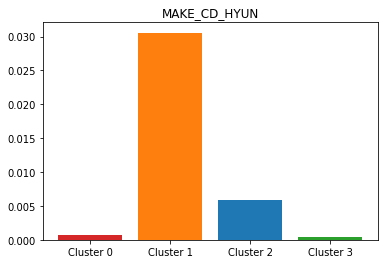

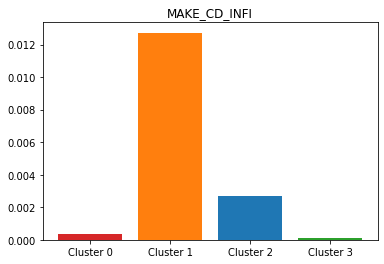

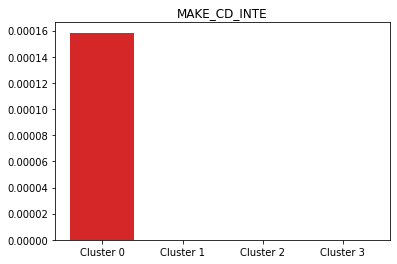

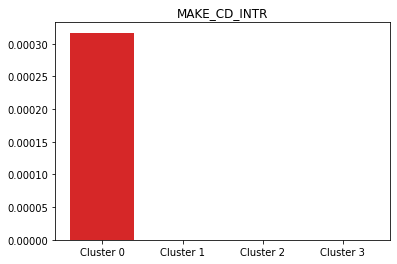

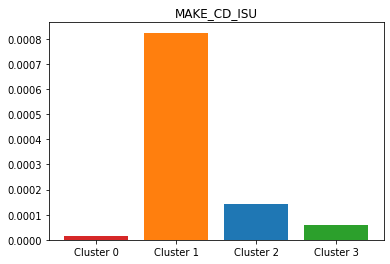

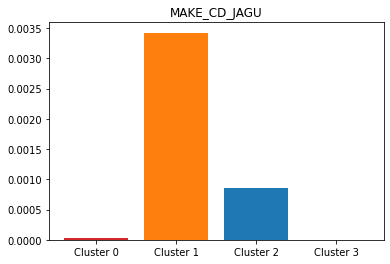

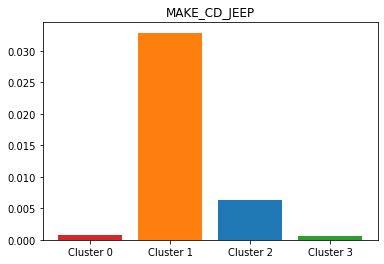

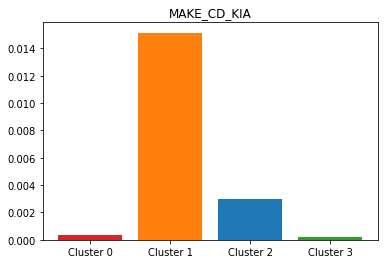

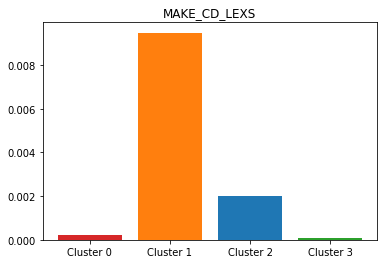

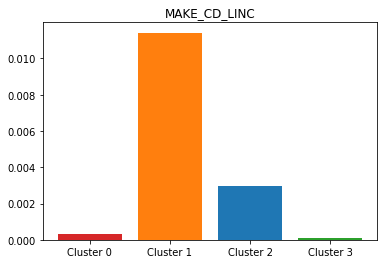

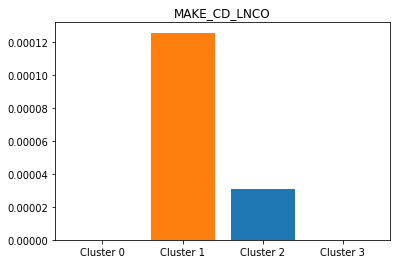

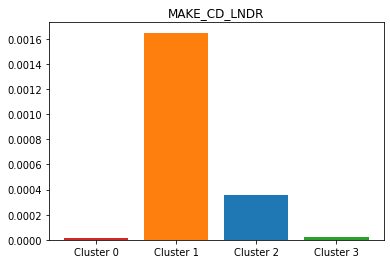

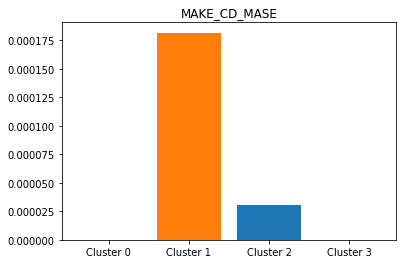

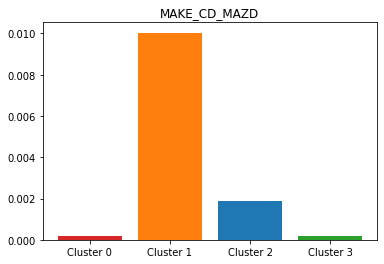

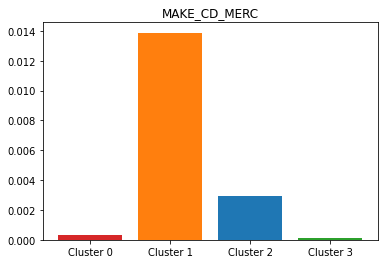

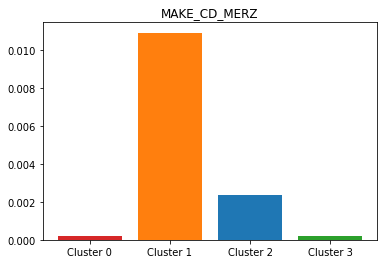

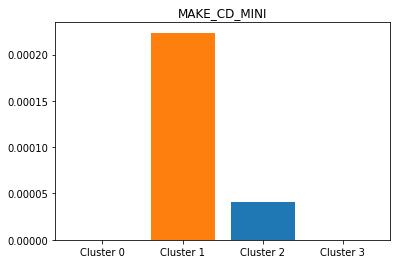

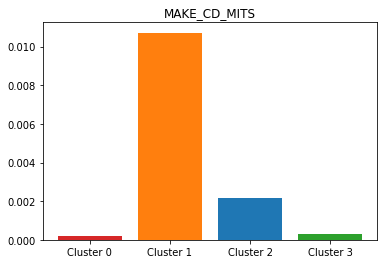

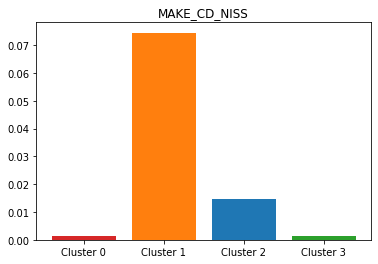

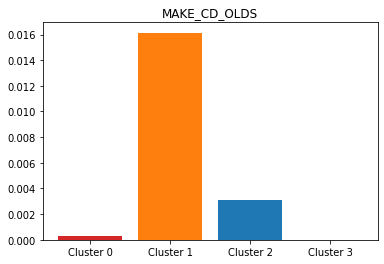

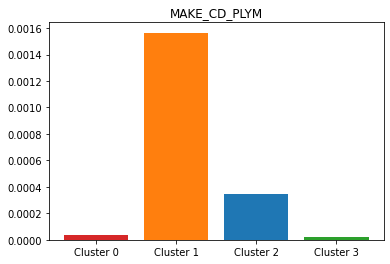

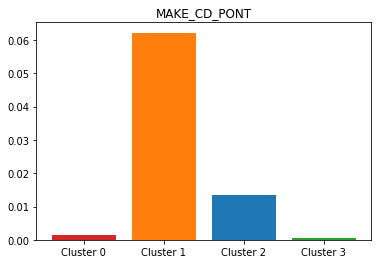

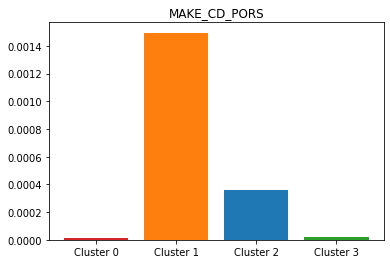

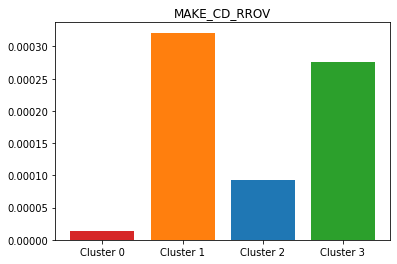

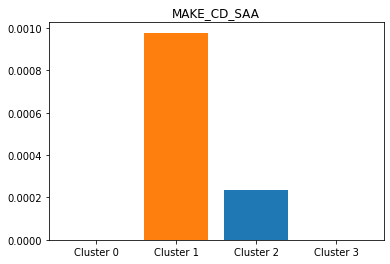

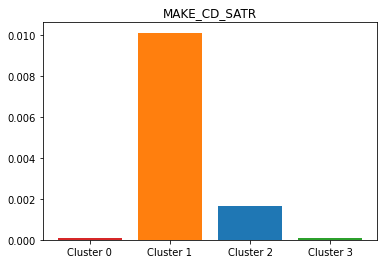

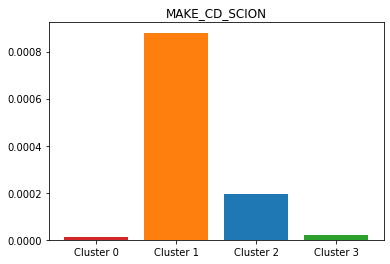

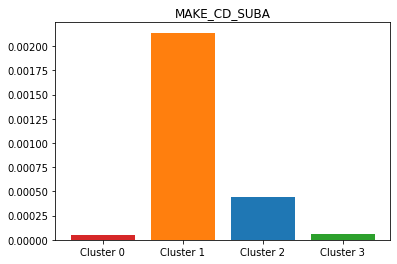

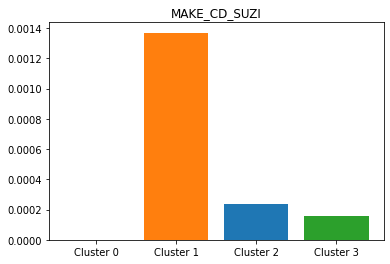

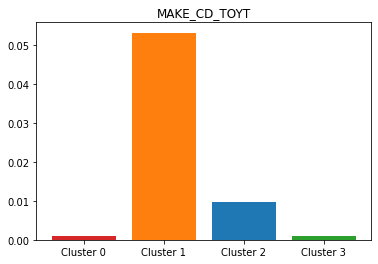

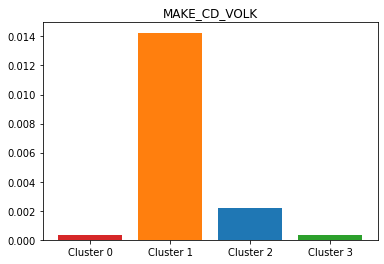

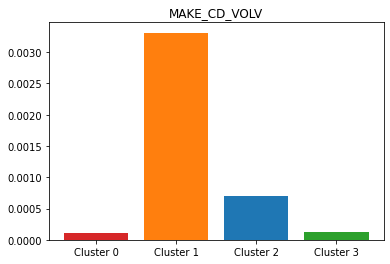

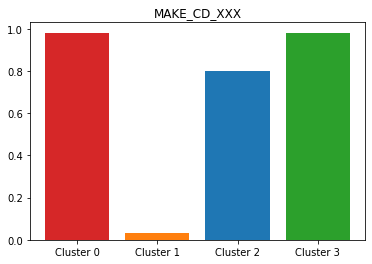

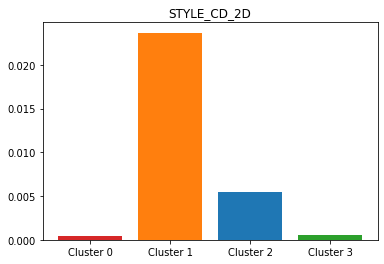

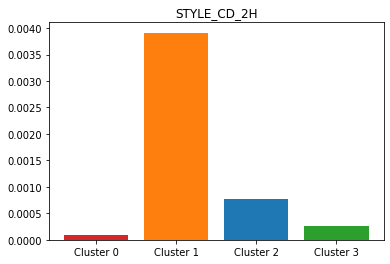

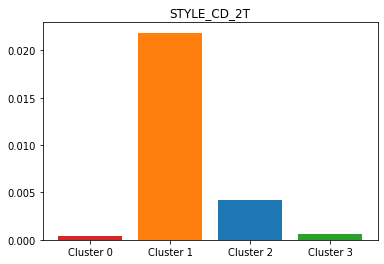

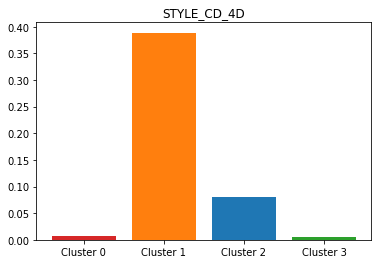

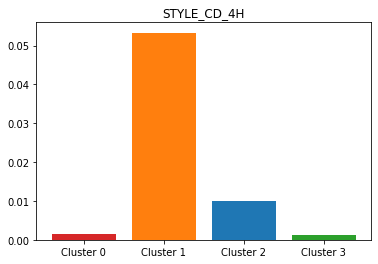

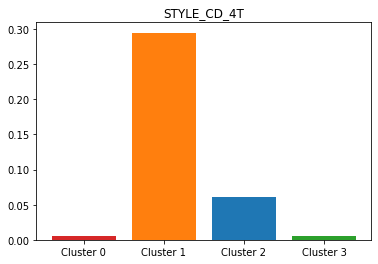

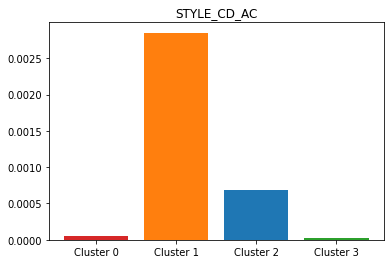

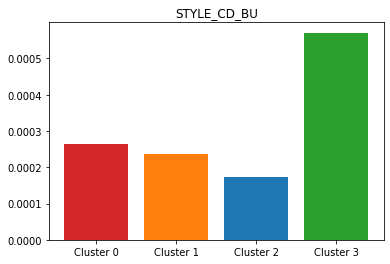

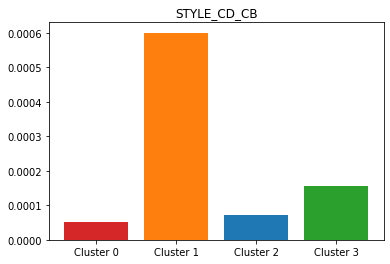

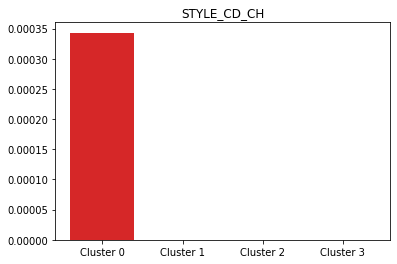

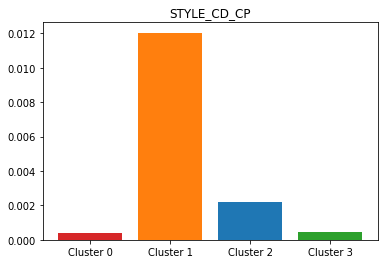

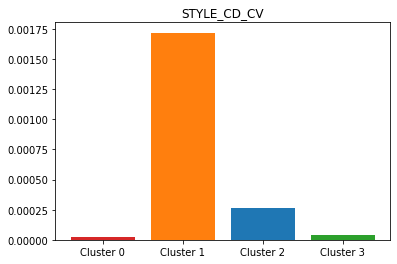

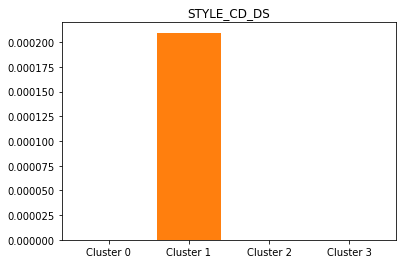

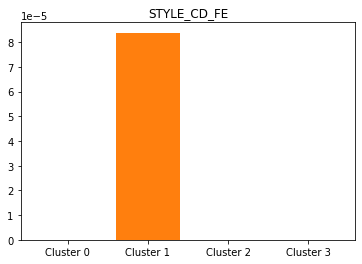

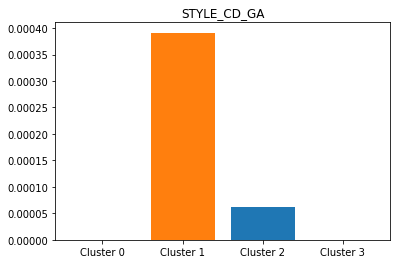

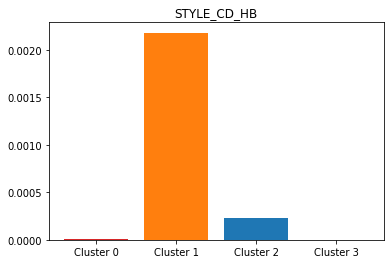

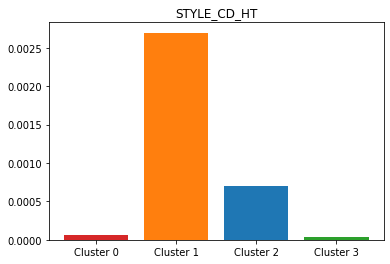

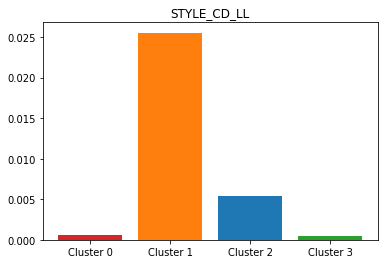

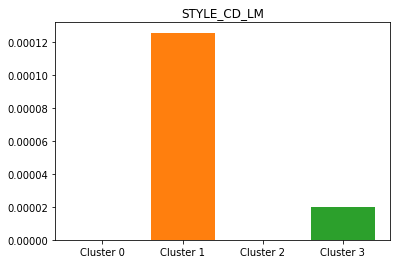

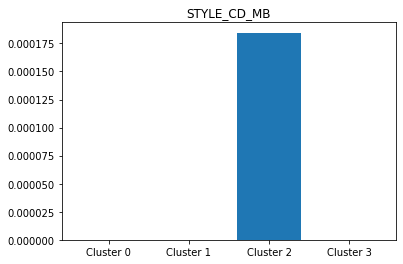

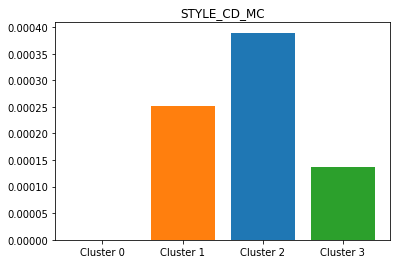

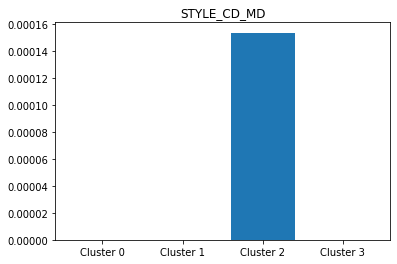

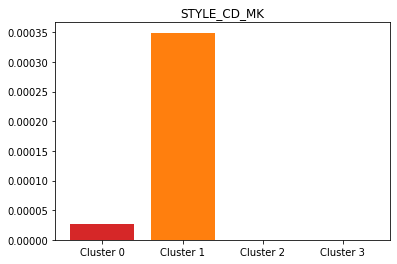

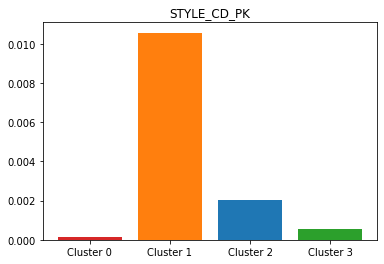

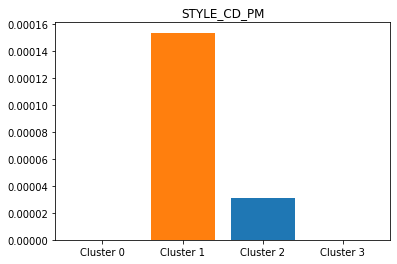

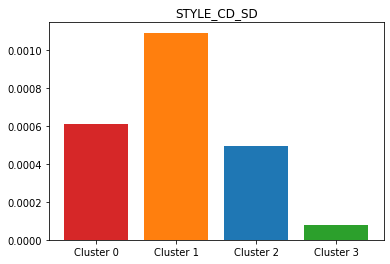

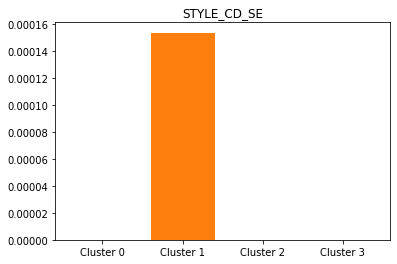

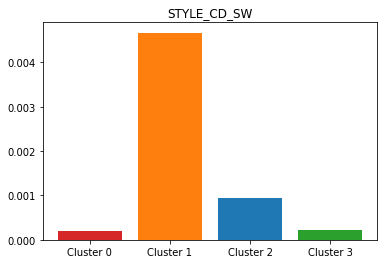

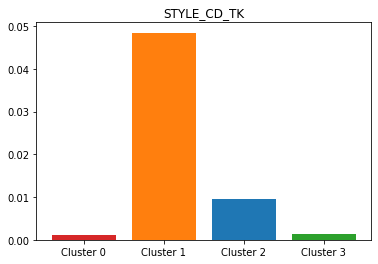

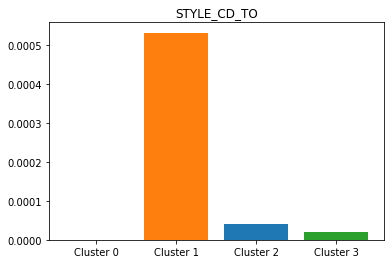

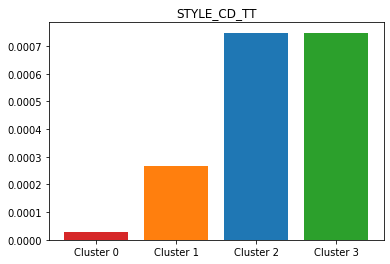

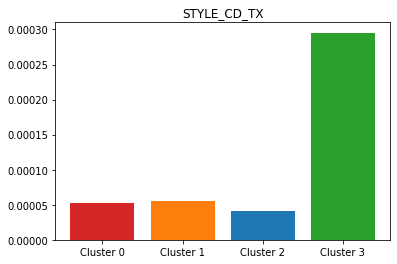

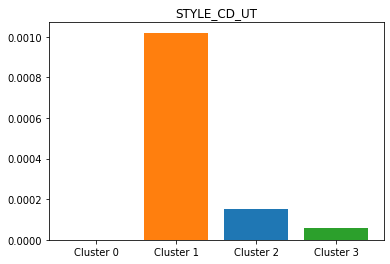

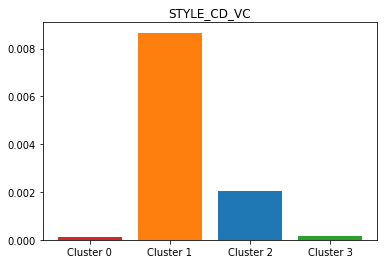

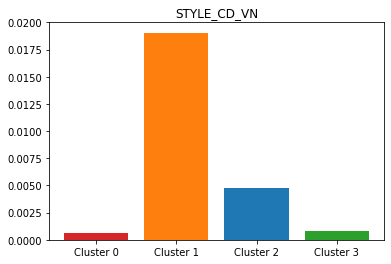

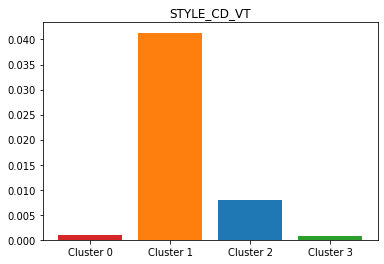

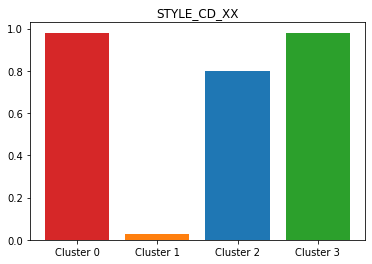

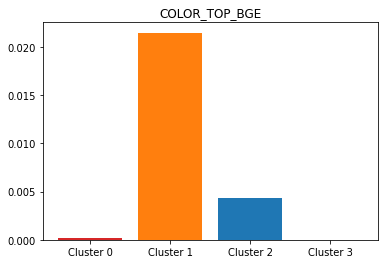

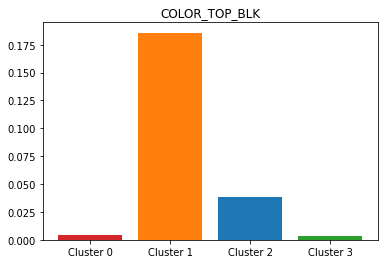

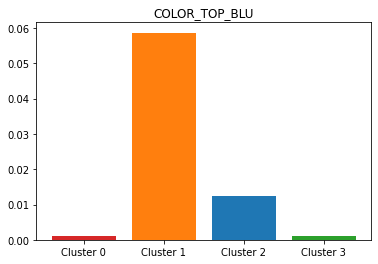

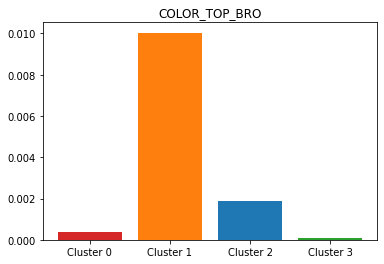

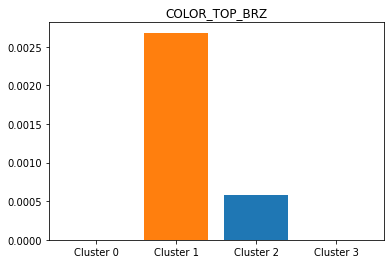

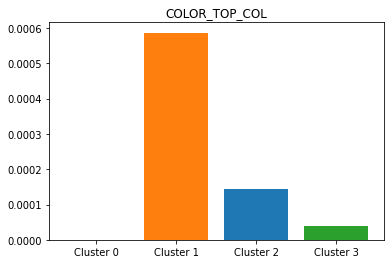

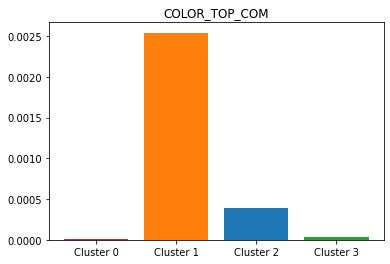

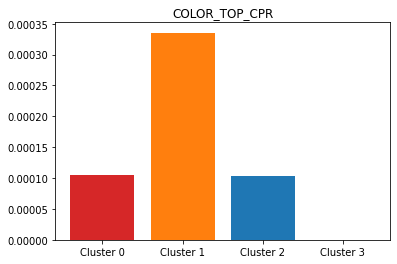

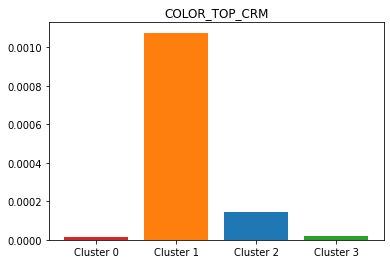

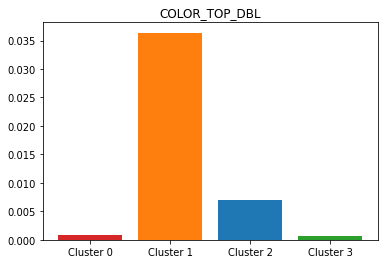

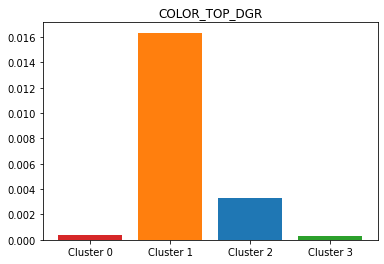

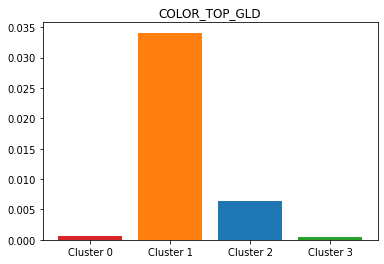

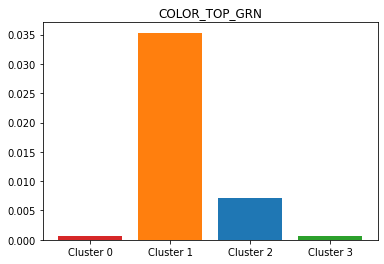

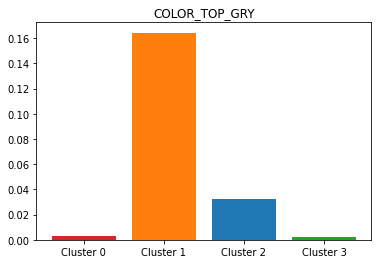

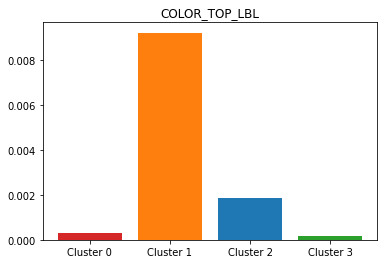

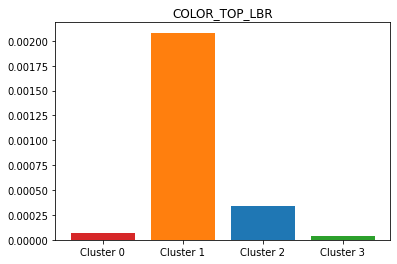

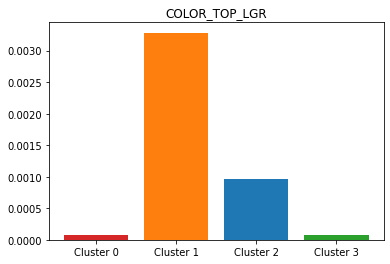

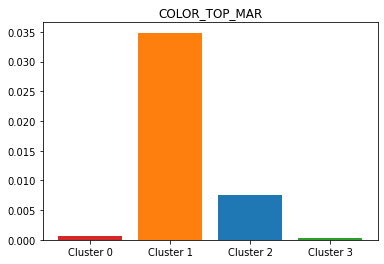

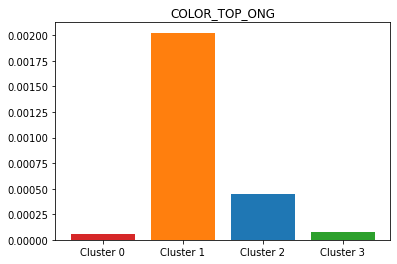

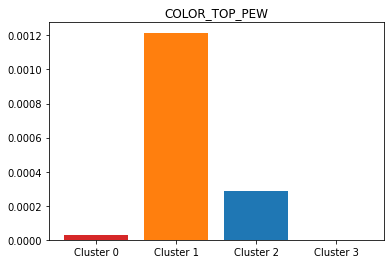

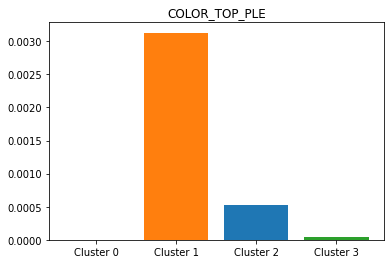

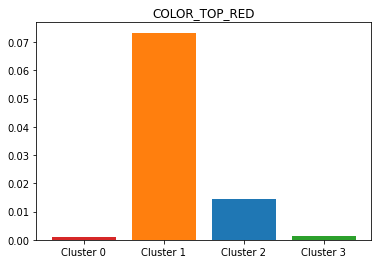

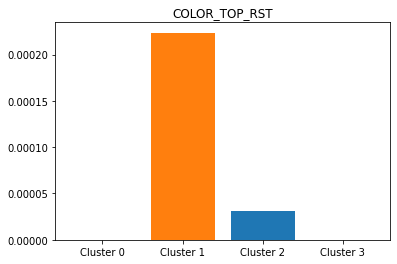

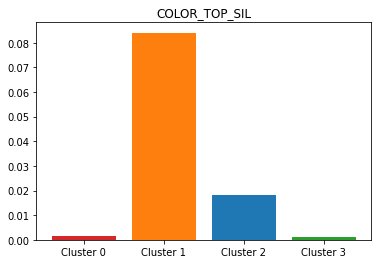

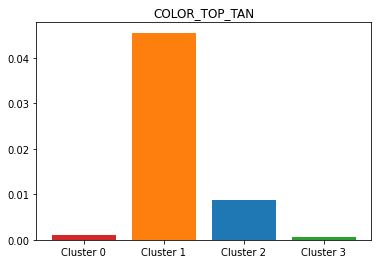

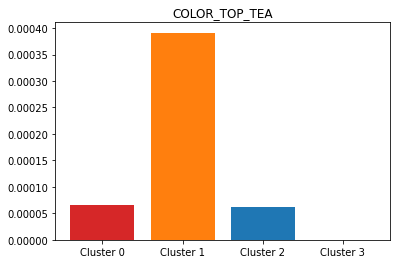

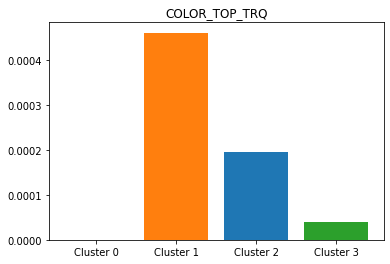

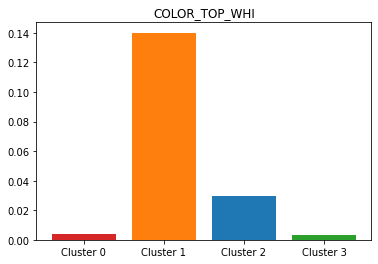

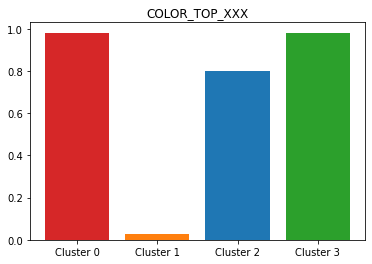

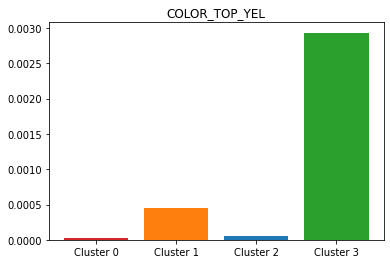

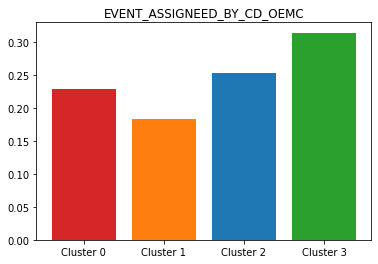

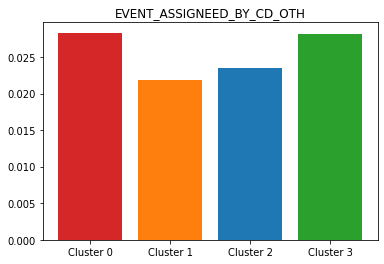

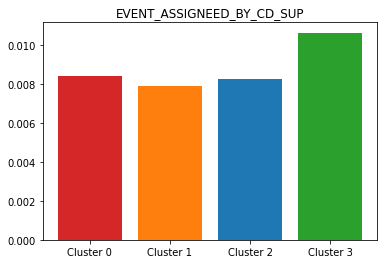

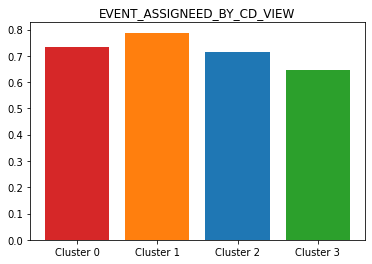

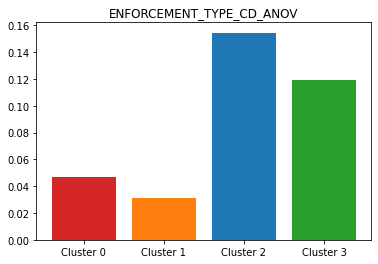

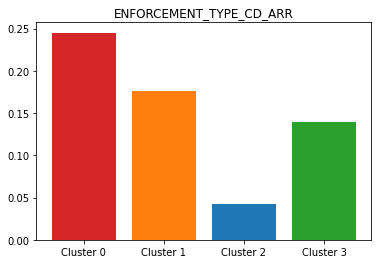

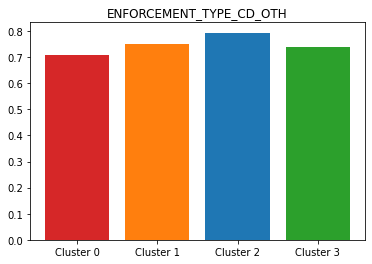

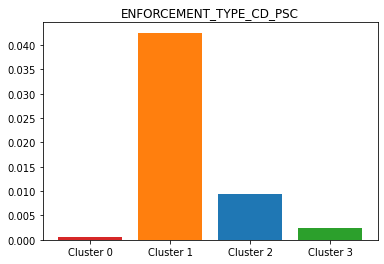

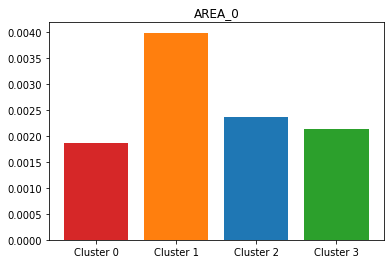

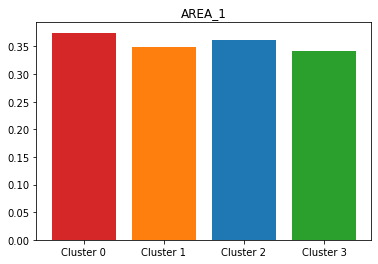

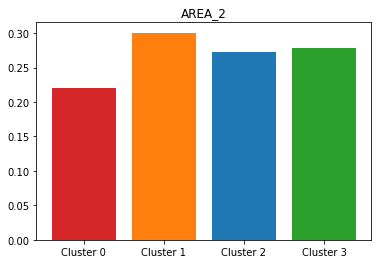

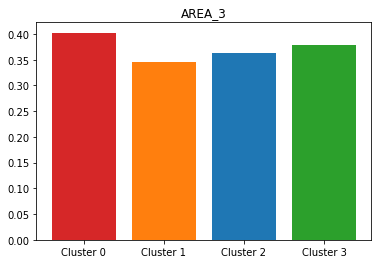

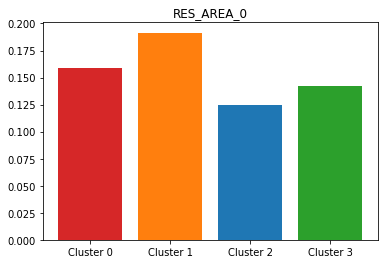

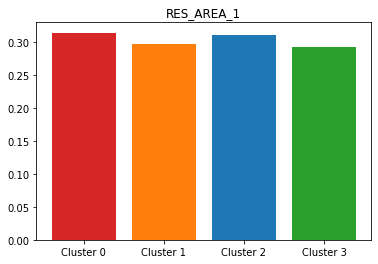

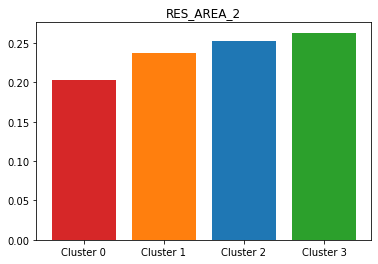

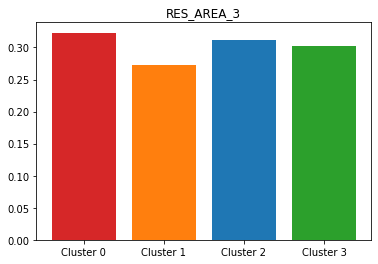

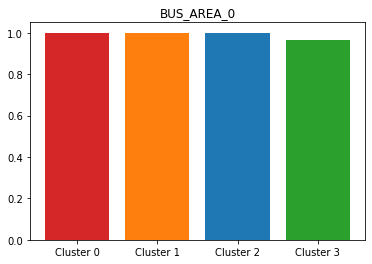

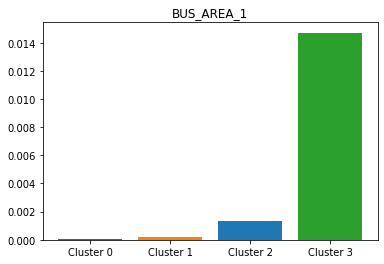

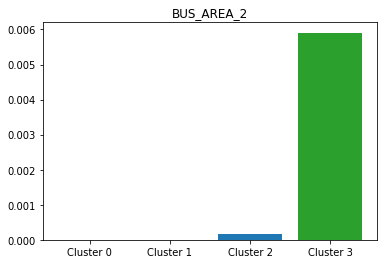

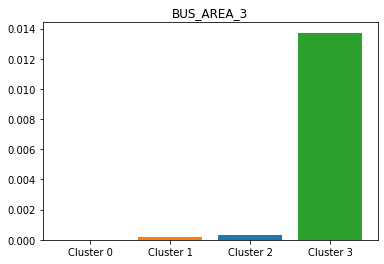

In [69]:
for col in sig_features:

    plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means[col], color=['tab:red', 'tab:orange', 'tab:blue' ,'tab:green'])
    plt.title(col)
    plt.show()

Cluster 0: SEX_CODE_CD_F, RACE_CODE_CD_WHT

Cluster 1: SEARCH_CANNABIS_I, SEARCH_HEROIN_I, SEARCH_CANNABIS_AMOUNT, SEARCH_HEROIN_AMOUNT

Cluster 2: GANG_NARCOTIC_RELATED_I, AGE, HANDCUFFED_I, NUMBER_OF_PERSONS_DISPERSED, PAT_DOWN_I, SEARCH_I, SEX_CODE_CD_X

Cluster 3: SEX_CODE_CD_F, HEIGHT, WEIGHT, WEAPON_OR_CONTRABAND_FOUND_I, CANNABIS_I, COCAINE_I, RACE_CODE_CD_BLK, RACE_CODE_CD_WHT

## Cluster 0

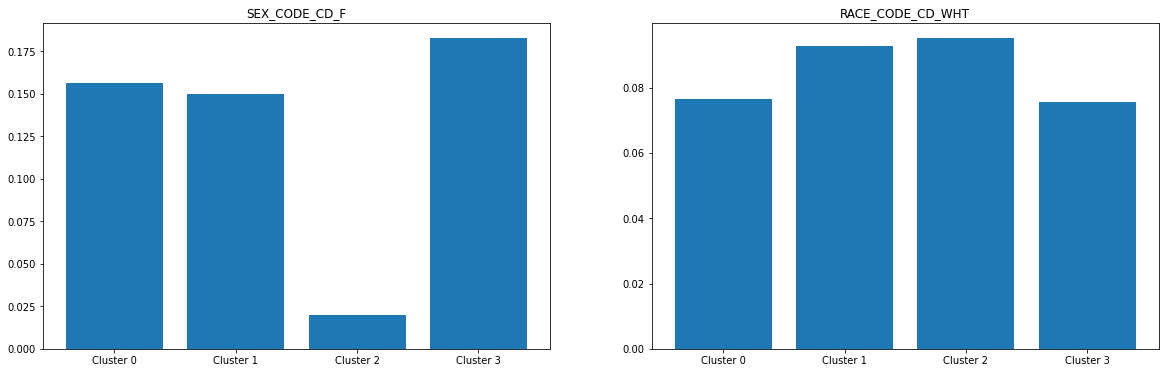

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEX_CODE_CD_F'])
plt.title('SEX_CODE_CD_F')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['RACE_CODE_CD_WHT'])
plt.title('RACE_CODE_CD_WHT')

plt.show()

## Cluster 1

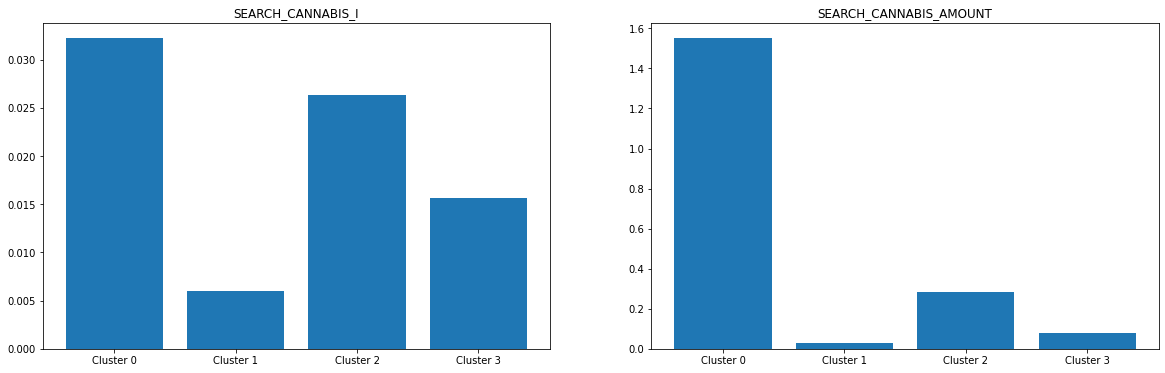

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_CANNABIS_I'])
plt.title('SEARCH_CANNABIS_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_CANNABIS_AMOUNT'])
plt.title('SEARCH_CANNABIS_AMOUNT')

plt.show()

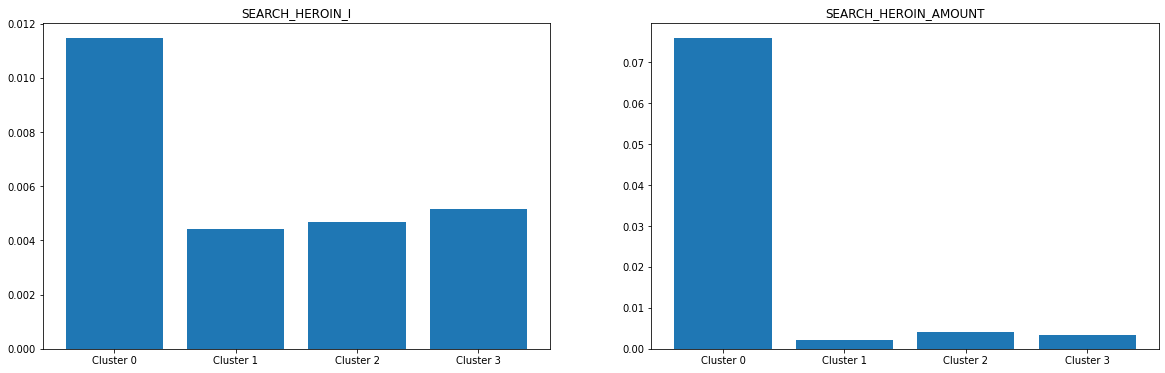

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_HEROIN_I'])
plt.title('SEARCH_HEROIN_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_HEROIN_AMOUNT'])
plt.title('SEARCH_HEROIN_AMOUNT')

plt.show()

## Cluster 2

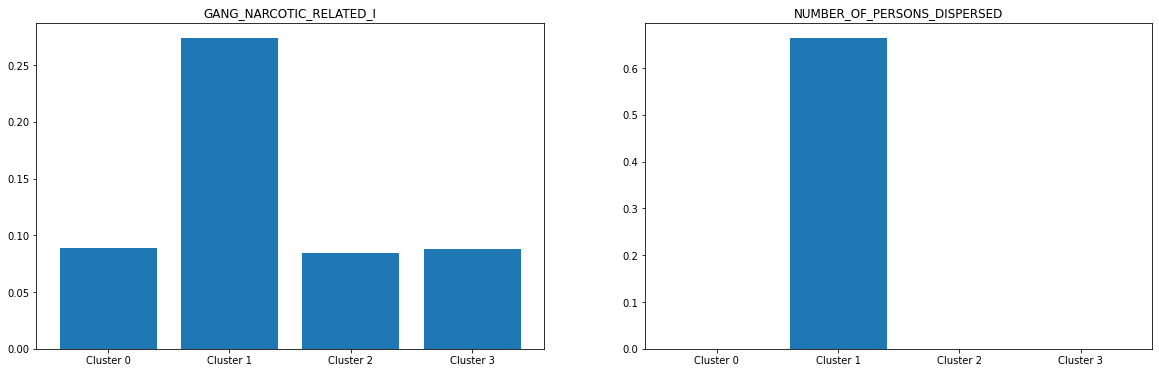

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['GANG_NARCOTIC_RELATED_I'])
plt.title('GANG_NARCOTIC_RELATED_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['NUMBER_OF_PERSONS_DISPERSED'])
plt.title('NUMBER_OF_PERSONS_DISPERSED')

plt.show()

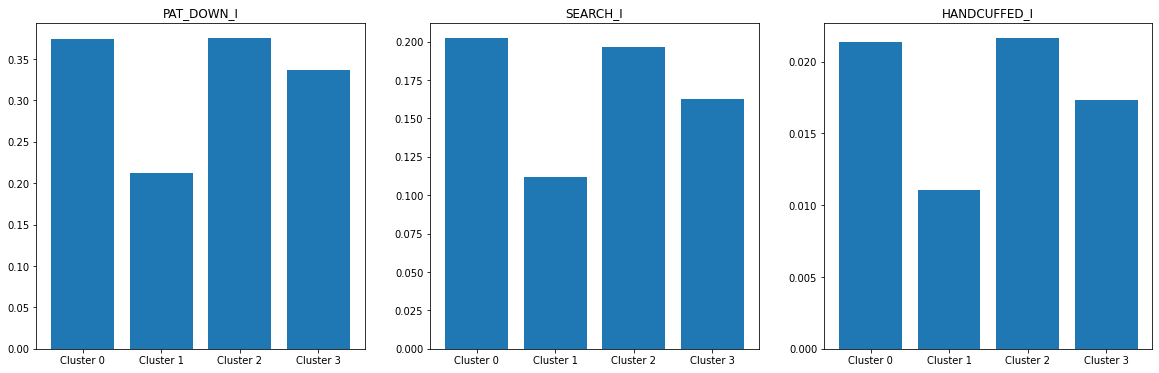

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['PAT_DOWN_I'])
plt.title('PAT_DOWN_I')

plt.subplot(1, 3, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_I'])
plt.title('SEARCH_I')

plt.subplot(1, 3, 3)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['HANDCUFFED_I'])
plt.title('HANDCUFFED_I')

plt.show()

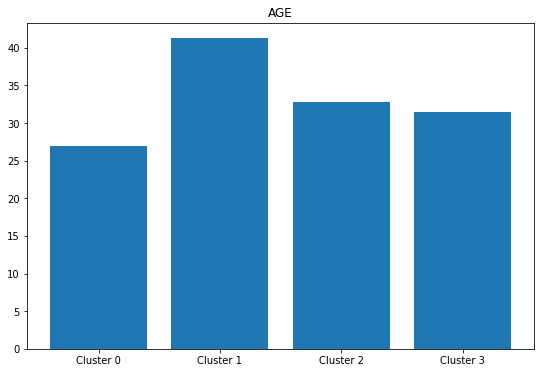

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['AGE'])
plt.title('AGE')

plt.show()

## Cluster 3

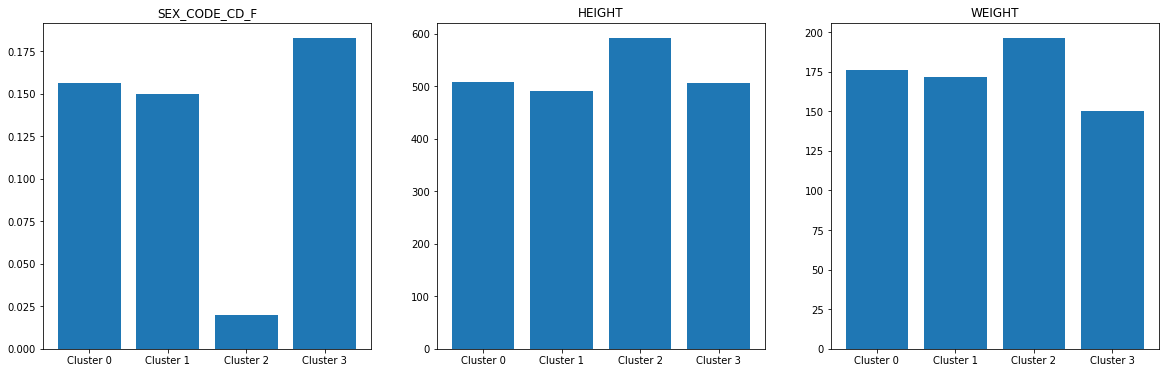

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEX_CODE_CD_F'])
plt.title('SEX_CODE_CD_F')

plt.subplot(1, 3, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['HEIGHT'])
plt.title('HEIGHT')

plt.subplot(1, 3, 3)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['WEIGHT'])
plt.title('WEIGHT')

plt.show()

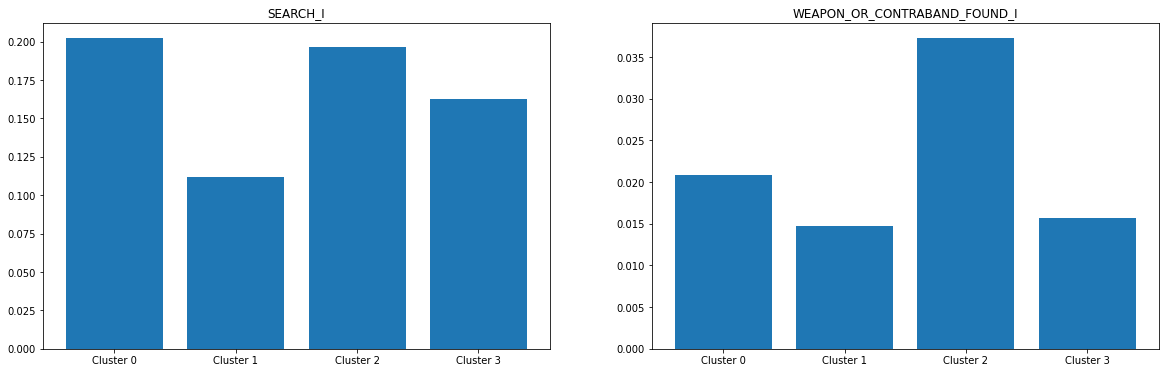

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_I'])
plt.title('SEARCH_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['WEAPON_OR_CONTRABAND_FOUND_I'])
plt.title('WEAPON_OR_CONTRABAND_FOUND_I')

plt.show()

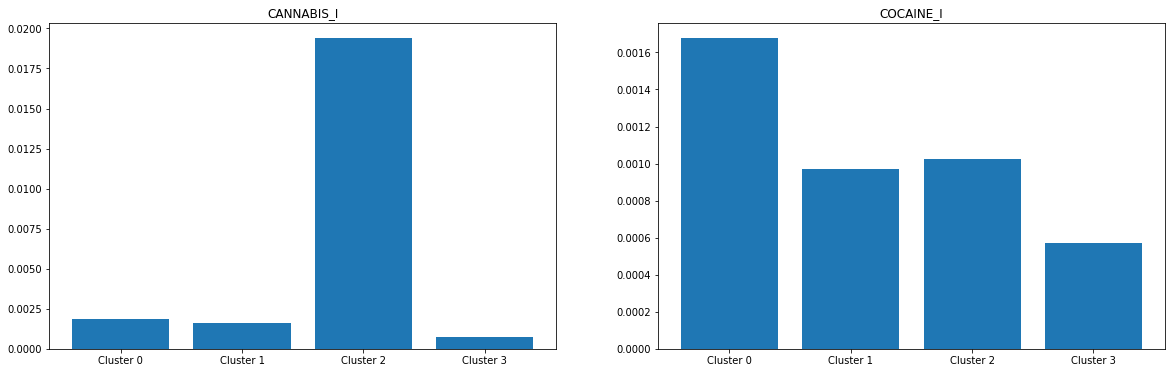

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['CANNABIS_I'])
plt.title('CANNABIS_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['COCAINE_I'])
plt.title('COCAINE_I')

plt.show()

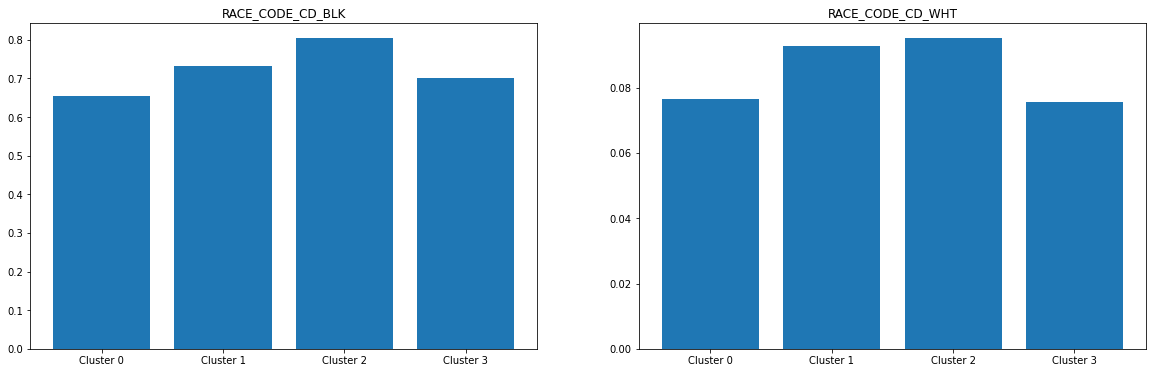

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['RACE_CODE_CD_BLK'])
plt.title('RACE_CODE_CD_BLK')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['RACE_CODE_CD_WHT'])
plt.title('RACE_CODE_CD_WHT')

plt.show()